# Project Notes

## References


* https://www.geeksforgeeks.org/machine-learning/mnist-dataset/
* https://medium.com/@kjkjindal/building-and-understanding-variational-autoencoders-vaes-a-simple-mnist-example-9f3a774b5153
* https://towardsdatascience.com/uncovering-anomalies-with-variational-autoencoders-vae-a-deep-dive-into-the-world-of-1b2bce47e2e9/
* https://arxiv.org/html/2408.13561v1
* https://www.emergentmind.com/topics/convolutional-variational-autoencoders-cnn-vaes
* https://www.geeksforgeeks.org/deep-learning/save-and-load-models-in-pytorch/


## Quick Discussion of Baseline Models

In addition to variational autoencoders, we include deterministic (Conv VAE) and discriminative (Digit Classifier) baselines to isolate the effects of architectural inductive bias (FC VAE vs Conv VAE) and probabilistic regularization. A convolutional autoencoder serves as a deterministic counterpart to the Conv VAE, while a supervised digit classifier provides a task-driven baseline.

We'll define three baseline models:

* Supervised Digit Classifier (compares discriminative vs generative)
* Convolutional Autoencoder (compares deterministic vs probabilistic models (ConvAE vs ConvVAE))model trade-offs and is important for label shift experiments)
* FC VAE (compares architectural inductive bias effects within VAEs)


## CNN

A Digit Classifier is a discriminative, task-driven model. It is a supervised learning model and a baseline for how well (or poorly) these kinds of models generalize vs generative modeling.

It will highlight why uncertainty in a model is important.

We'll use a simple Convolutional Neural Network (CNN) is this case, with 2 convolutional layers, ReLU activations, one hidden fully connected layer, and a softmax output.

Since classification wants invariance, we'll need to use pooling to improve robustness to small shifts. Pooling reduces spatial resolution, introduces traditional invariance, and expands the effective receptive field. Also makes large kernel sizes unnecessary.

The classifier output will be logits, instead of probabilities.

A kernel size of 3 is the modern standard for CNNs. It allows the network to see just enough of the context to understand locality, avoids smoothing details, and encourages hierarchical feature learning.

In summary, 3×3 convolutional kernels are a standard choice in discriminative CNNs that balances parameter efficiency with local feature extraction.

Including dropout in the classifier head mitigates overconfidence and better reflects uncertainty under distribution shift.

Dropout randomly sets a subset of activations to zero on each forward pass. This forces the network to learn without relying on any single neuron, developing redundant, distributed representations of the data.

## CAE
A convolutional autoencoder (CAE) learns:

$f_{\theta}(x) \approx x$

but **without probabilistic modeling**.

Key properties:

* Deterministic latent representation
* Optimized only for reconstruction
* No KL divergence
* No sampling (reparameterization)
* No uncertainty

Structurally the CAE will mirror the ConvVAE, but the latent vector $z$ will be a point, instead of a distribution.

The loss function will only contain reconstruction loss.

## Quick Discussion of VAEs

A variational Autoencoder (VAE) is a "class of generative models that combine deep learning and probabilistic modeling to learn compact representations of data." [Medium Article](https://medium.com/@kjkjindal/building-and-understanding-variational-autoencoders-vaes-a-simple-mnist-example-9f3a774b5153)

**Key Components of a VAE**

* **Encoder**: Maps input data to a latent distribution (mean & variance)

* **Latent Sampling**: Samples latent variables using the reparameterization trick to enable backpropagation

* **Decoder**: Reconstructs data from the sampled latent representation

The VAE loss function has two parts:

* **Reconstruction Loss**: Ensures the decoder outputs resemble the original input

* **KL Divergence Loss**: Also called Regularization. Encourages the latent space to follow a Gaussian prior, helping generate smooth outputs

These parts are combined together into what's called the Evidence Lower Bound (ELBO).

ELBO = Reconstruction - Regularization

## FC VAE

This model will demonstrate pure variational methodology, with minimal inductive bias. This VAE has a simpler construction, but the main downside is that it loses an understanding of spatial structure.

## Conv VAE

This model is more practically relavent, and will show how architectural inductive bias improves generative modeling and robustness as it maintains an understanding of local spatial structure.

Inductive bias understands that nearby pixels are related, shapes are compositional, and features are hierarchical.

We'll compare the baseline models with the convolutional VAE, trained under identical conditions, and evaluate reconstruction fidelity, latent uncertainty, and shift detection performance.

Using a kernel size of 4 and stride of 2, downsampling is smoother, decoder inersion via ConvTranspose is easier, and feature maps align cleanly (28 -> 14 -> 7). This slightly larger kernel size (vs the CNN) captures a broader spatial context and improves generative quality, as the VAE needs to model pixel-level dependencies to reconstruct fine details.

Generative models employ slightly larger kernels to facilitate invertible downsampling and reconstruction.

The trade-off of modifying **beta** in the loss function: as beta increases, reconstruction gets worse but latent space gets more regularized

## Training Loss Functions

Loss functions for each kind of model:
* **CNN**: Cross Entropy Loss
* **CAE**: BCE (to match VAEs)
* **VAE**: BCE + KL = ELBO

Notes:

* The convolutional autoencoder is trained using BCE to match, and more easily compare with, the VAEs, despite MSE being a typical practice

* The CNN used cross entropy loss, which combines LogSoftmax and NLLLoss

## Model Evaluations

Notes:

There are three kinds of models, so their evaluation looks slightly different.

* CNN classifier
* * Input: image.
* * Output: class logits or probabilities over digits 0-9.
* * Natural metrics: accuracy, per-class accuracy, confusion matrix, maybe negative log-likelihood.

* Conv autoencoder (AE)
* * Input: image.
* * Output: reconstructed image.
* * Natural metrics: reconstruction error (MSE), plus OOD proxy via reconstruction error.

* VAEs (FC and conv)
* * Input: image.
* * Output: reconstructed image + latent distribution parameters (mean, logvar).
* * Natural metrics: reconstruction error, KL term, ELBO (recon + KL), plus detection performance using recon error (and/or latent-space scores).

The main story for “shift detection” will be: how much do scores (accuracy, recon error, ELBO, etc.) change when we apply each shift to the test data?

## Generating Evaluation Data:

For the Classifier:

* We'll likely see a drop in accuracy when moving from clean to shifted datasets

* We'll also expect higher entropy on shifted data

For the Autoencoder / VAEs:

* We'll likely see an increase in mean reconstruction error on shifted data

* And for VAEs, often anomalies show higher recon error and sometimes different KL behavior

# Initialize imports and Shared Variables

In [ ]:
#imports and global vars
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score
import umap

# Common variables
data_root = './data'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# train/test data batch size
batch = 64

# Filepaths for saving trained models and evals
cnn_filePath = 'cnn_model.pth'
cnn_training_eval_filePath = 'cnn_training_evals.json'
cae_filePath = 'cae_model.pth'
cae_training_eval_filePath = 'cae_training_evals.json'
fcVAE_filePath = 'fcVAE_model.pth'
fcVAE_training_eval_filePath = 'fcVAE_training_evals.json'
convVAE_filePath = 'convVAE_model.pth'
convVAE_training_eval_filePath = 'convVAE_training_evals.json'
convVAE4_filePath = 'convVAE4_model.pth'
convVAE4_training_eval_filePath = 'convVAE4_training_evals.json'

# Save evals
shifted_eval_filePath = 'shifted_evals.json'
latent_eval_filePath = 'latent_results.pt'

print("Using device:", device)


Using device: cuda


# Establishing the MNIST Datasets

First define some shared variables and a data viewing function to ensure the datasets are being handled properly.

The datasets will be loaded and processed with PyTorch.

In [ ]:
def viewData(dataset, title):
  # Create a DataLoader to load the dataset in batches
  loaded_data = DataLoader(
      dataset,
      batch_size=1,
      shuffle=False)

  # Create a figure to display the images
  plt.figure(figsize=(15, 6))
  plt.suptitle(title)

  # Print the first few images in a row
  for i, (image, label) in enumerate(loaded_data):
      if i < 10:  # Print the first 10 samples
          plt.subplot(2, 5, i + 1)
          plt.imshow(image[0].squeeze(), cmap='gray')
          plt.title(f"Label: {label.item()}")
          plt.axis('off')
      else:
          break  # Exit the loop after printing samples
  plt.tight_layout()
  plt.show()

## Load the Training MNIST Dataset

Loading MNIST Training Data...


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.7MB/s]


Viewing MNIST Training Data: 


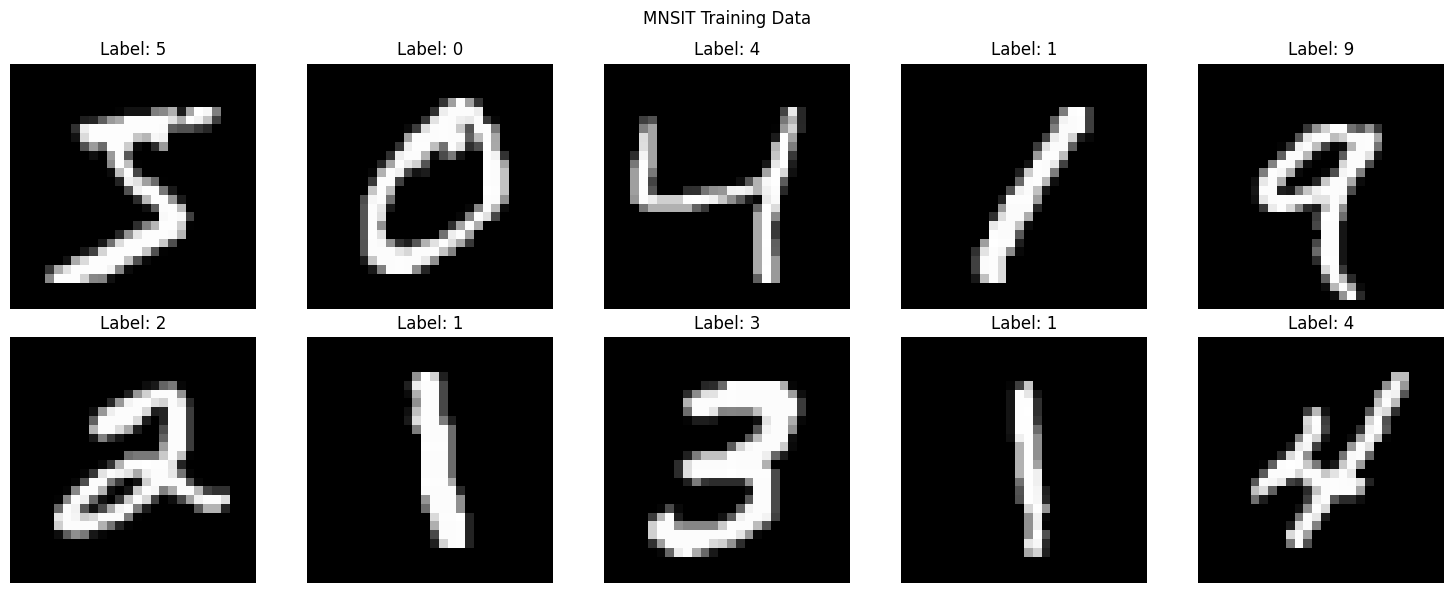

In [ ]:
# Define a transform to convert images to PyTorch tensors and normalize to [0.0, 1.0]
standard_transform = transforms.Compose([transforms.ToTensor()])

# Load the MNIST training dataset with the specified transformation
print("Loading MNIST Training Data...")
# Key parameters = standard transform and True train set
mnist_train_data = datasets.MNIST(
      root=data_root,
      train=True,
      download=True,
      transform=standard_transform)

print("Viewing MNIST Training Data: ")
viewData(mnist_train_data, "MNSIT Training Data")

## Load the Testing MNIST Dataset

Follows a similar process to loading the training MNIST dataset but simply changes the `train` parameter from `True` to `False`.

Loading MNIST Testing Data...
Viewing MNIST Testing Data: 


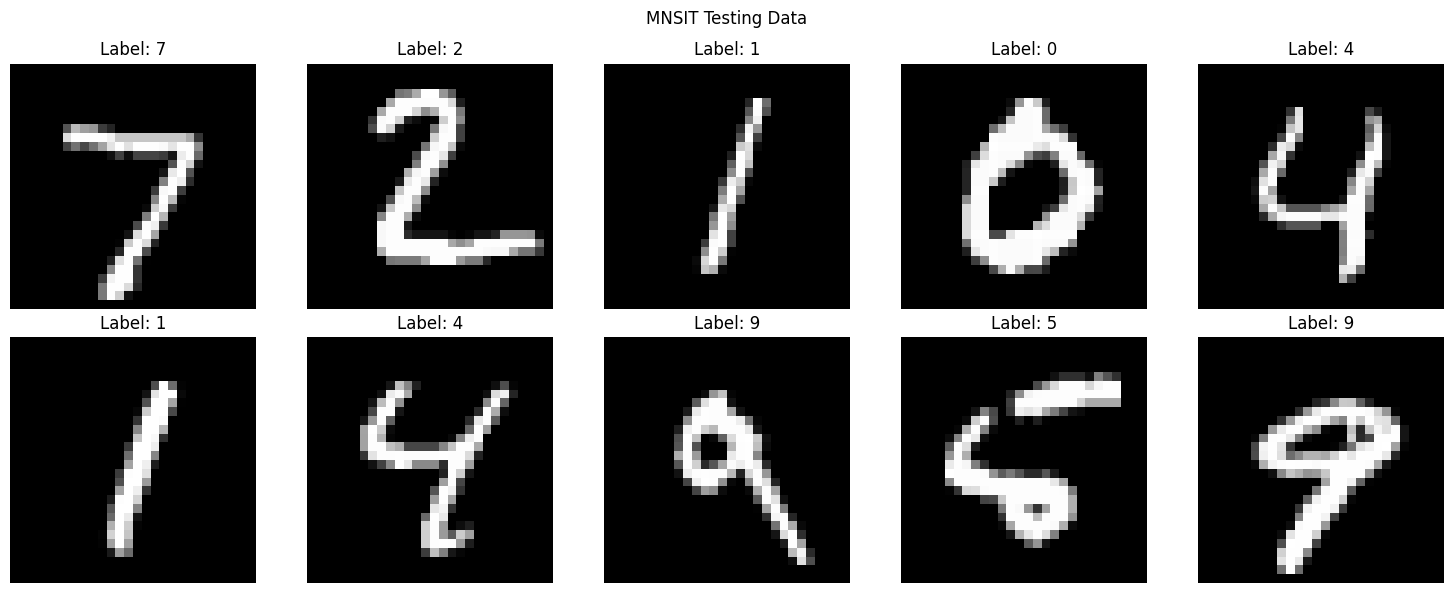

In [ ]:
print("Loading MNIST Testing Data...")
# Key parameters = standard transform and False train set
mnist_test_data = datasets.MNIST(
      root=data_root,
      train=False,
      download=True,
      transform=standard_transform)

print("Viewing MNIST Testing Data: ")
viewData(mnist_test_data, "MNSIT Testing Data")

## Create a Rotated Version of the MNIST Test Dataset (A Covariate Shift)

Create Rotated MNIST Testing Data...
Viewing Rotated MNIST Testing Data: 


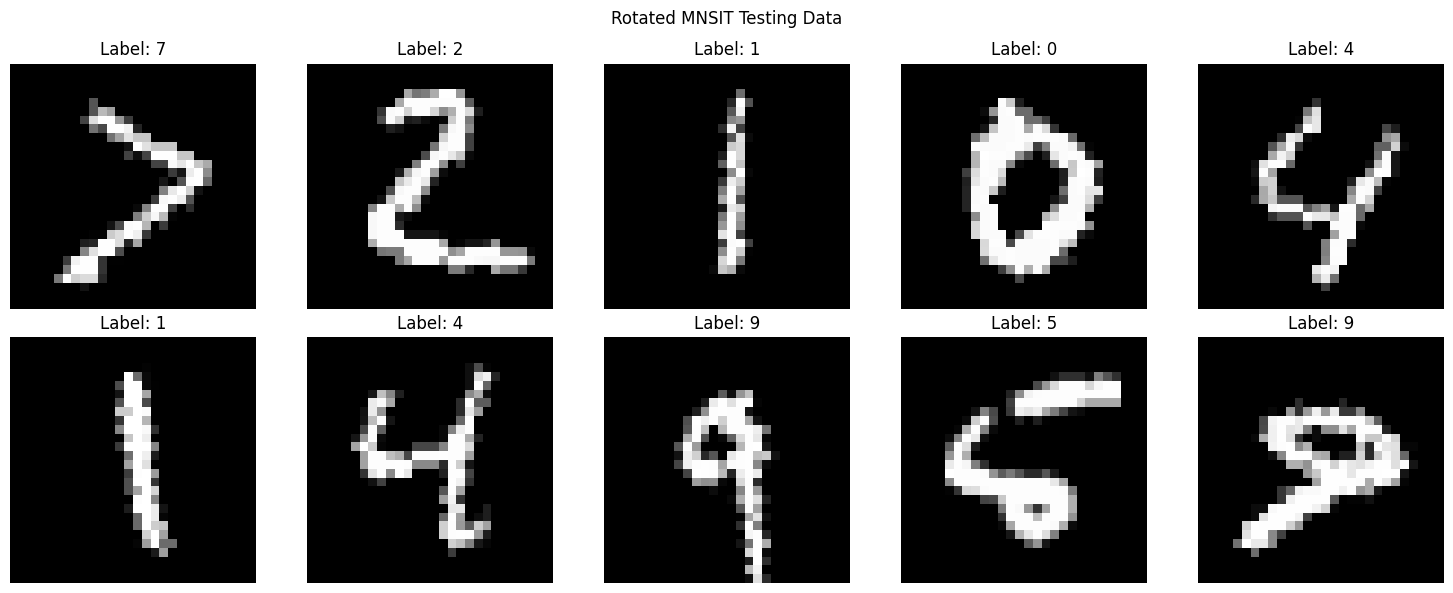

In [ ]:
# Define a rotation transformation
rotation_transform = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor()
])

print("Create Rotated MNIST Testing Data...")
# Key parameters = rotation transform and False train set
rotated_mnist_test_data = datasets.MNIST(
      root=data_root,
      train=False,
      download=True,
      transform=rotation_transform)

print("Viewing Rotated MNIST Testing Data: ")
viewData(rotated_mnist_test_data, "Rotated MNSIT Testing Data")


## Create a Noisy Version of the MNIST Test Dataset (A Noise Shift)

Create Noisy MNIST Testing Data...
Viewing Noisy MNIST Testing Data: 


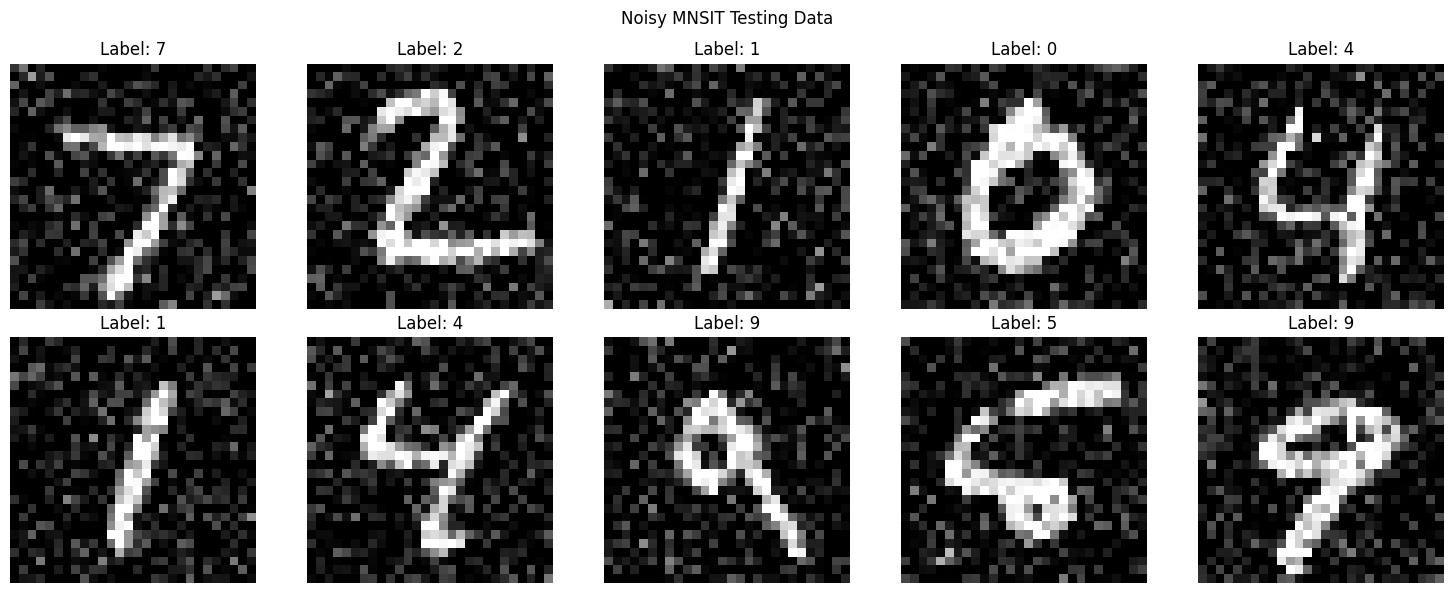

In [ ]:
class AddGaussianNoise:
    def __init__(self, mean=0.0, std=0.2):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn_like(tensor) * self.std + self.mean
        return torch.clamp(tensor + noise, 0.0, 1.0)

# Define a guassian noise transformation
noisy_transform = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise()
])

print("Create Noisy MNIST Testing Data...")
# Key parameters = noisy transform and False train set
noisy_mnist_test_data = datasets.MNIST(
      root=data_root,
      train=False,
      download=True,
      transform=noisy_transform)

print("Viewing Noisy MNIST Testing Data: ")
viewData(noisy_mnist_test_data, "Noisy MNSIT Testing Data")

## Add a Randomly Placed Black Square to the MNIST Test Dataset (Occlusion) (A Covariate Shift)

Create Occluded MNIST Testing Data...
Viewing Occluded MNIST Testing Data: 


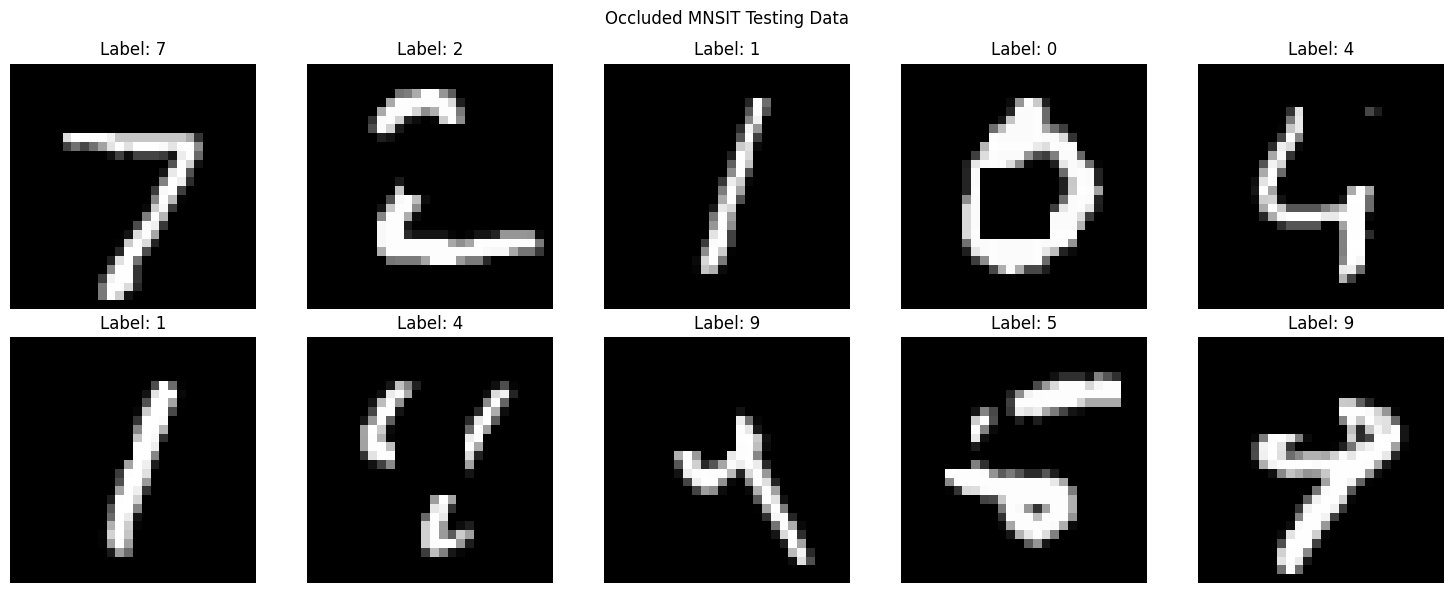

In [ ]:
class RandomOcclusion:
    def __init__(self, size=8):
        self.size = size

    def __call__(self, tensor):
        x = tensor.clone()
        _, h, w = x.shape
        top = torch.randint(0, h - self.size, (1,))
        left = torch.randint(0, w - self.size, (1,))
        x[:, top:top+self.size, left:left+self.size] = 0.0
        return x

# Define an occlusion transformation
occlusion_transform = transforms.Compose([
    transforms.ToTensor(),
    RandomOcclusion(size=8)
])

print("Create Occluded MNIST Testing Data...")
# Key parameters = occlusion transform and False train set
occluded_mnist_test_data = datasets.MNIST(
      root=data_root,
      train=False,
      download=True,
      transform=occlusion_transform)

print("Viewing Occluded MNIST Testing Data: ")
viewData(occluded_mnist_test_data, "Occluded MNSIT Testing Data")

## Filter MNIST Test Dataset to Labels of 0-4 (A Label Shift)

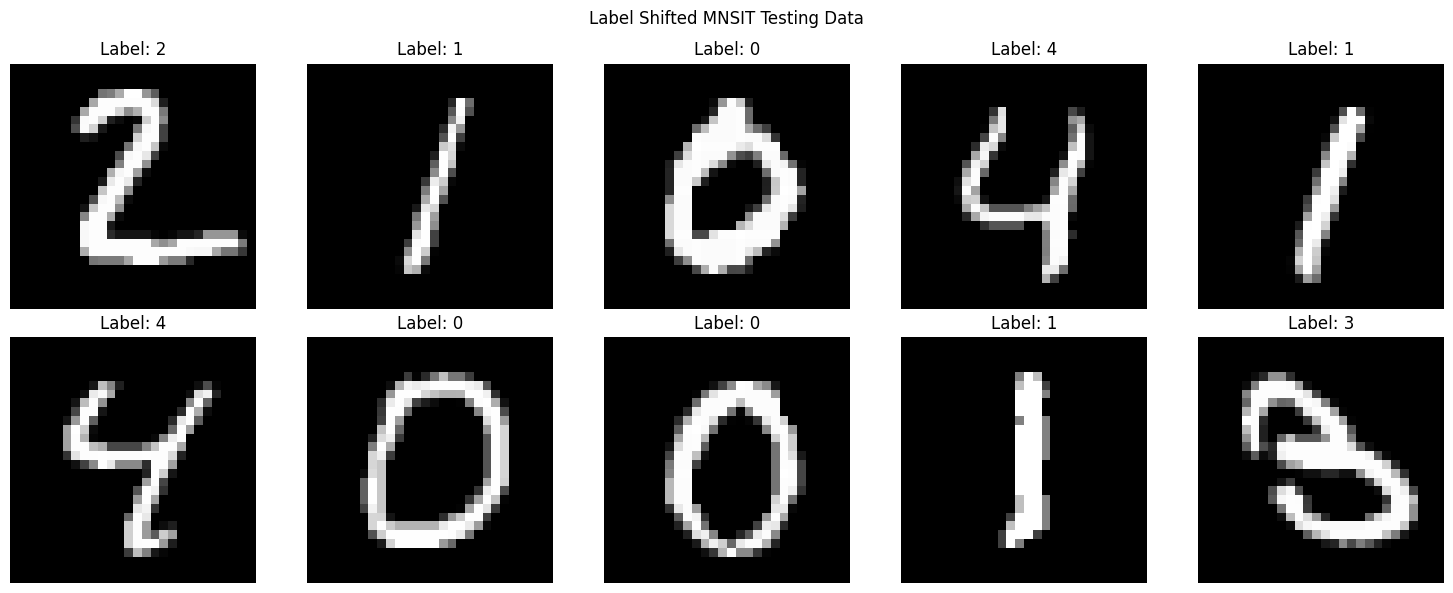

In [ ]:
def filter_labels(dataset, max_label):
    indices = [
        i for i, label in enumerate(dataset.targets)
        if label <= max_label
    ]
    return Subset(dataset, indices)

# Filter the MNIST test dataset for those with labels of 0-4
labelshift_mnist_test_data = filter_labels(mnist_test_data, max_label=4)

viewData(labelshift_mnist_test_data, "Label Shifted MNSIT Testing Data")

In [ ]:
# quick sanity check of dataset lenghts
def test_dataLength():
  assert(len(mnist_train_data) == 60000)
  assert(len(mnist_test_data) == 10000)
  assert(len(rotated_mnist_test_data) == 10000)
  assert(len(noisy_mnist_test_data) == 10000)
  assert(len(occluded_mnist_test_data) == 10000)
  assert(len(labelshift_mnist_test_data)>5000)

test_dataLength() #if nothing prints then it's a success!

# Summary of Dataset Variables:



*   Training Set: `mnist_train_data`
*   Standard Test Set: `mnist_test_data`
*   Rotated Test Set: `rotated_mnist_test_data`
*   Noisy Test Set: `noisy_mnist_test_data`
*   Occluded Test Set: `occluded_mnist_test_data`
*   Label Shift Test Set: `labelshift_mnist_test_data`

For the next steps, these datasets can be used by loading them with a DataLoader and modifying the `batch_size` and `shuffle` as needed:

```python
# Create a DataLoader to load the dataset in batches
  data_loader = DataLoader(
      dataset,
      batch_size=1, # 1 for display, 64 for training/testing
      shuffle=False) # False for testing, True for Training
```




# Defining The Models: Convolutional VAE and Baselines

## First, Define the Digit Classifier (CNN)

In [1]:
# Define a CNN as a Digit Classifier
class CNN_DigitClassifier(nn.Module):
  # init creates the network structure
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2), # 28 -> 14
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2) # 14 -> 7
    )

    self.classifier = nn.Sequential(
        nn.Linear(64*7*7, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, 10)
    )

  def forward(self, input):
    # flatten h
    h = self.features(input)
    h = h.view(h.size(0), -1)
    logits = self.classifier(h)
    return logits

NameError: name 'nn' is not defined

## Second, Define the Convolutional Autoencoder (CAE)

In [ ]:
# Define a Convolutional AE
class Conv_AE(nn.Module):
  # init creates the network structure
  def __init__(self, latent_dim=10):
    super().__init__()

    self.latent_dim = latent_dim

    # a convolutional encoder that produces the latent vector
    # each layer increases channel depth and reduces spatial resolution
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1), #28 -> 14
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), #14 -> 7
        nn.ReLU()
    )

    # latent vector, z
    flattened_dim = 64*7*7 #channels * height * width = 3136
    self.fc_latent = nn.Linear(flattened_dim, latent_dim)

    # a convolutional decoder to reconstruct images
    # reconstructs spatial structure (approx inverse of strided conv)
    self.fc_dec = nn.Linear(latent_dim, flattened_dim)

    # tranposed convolutional decoder
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # 7 -> 14
        nn.ReLU(),
        nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1), # 14 -> 28
        nn.Sigmoid() # decoder output models Bernoulli params for BCE loss
    )

  # encode input data to latent vector
  def encode(self, input):
    h = self.encoder(input)
    h = h.view(h.size(0), -1) #transition from spatial to global rep (flatten)
    return self.fc_latent(h)

  # decode latent sampling to reconstruction
  def decode(self, z):
    h = self.fc_dec(z) #from latent to feature map
    h = h.view(-1, 64, 7, 7) #reshape
    return self.decoder(h)

  def forward(self, input):
    z = self.encode(input)
    recon = self.decode(z)
    return recon, z

## Third, Define the Fully Connected VAE


In [ ]:
# Define a simple, fully connected (FC) VAE
class FC_VAE(nn.Module):
  # init creates the network structure
  # 784 = 28*28 = size of MNIST image in pixels
  # 400 hidden units is large enough to capture variation and small enough to regularize
  def __init__(self, input_dim=784, hidden_dim=400, latent_dim=10):
    super().__init__()

    self.latent_dim = latent_dim

    # a fully connected encoder that produces logvar and mean of the latent space
    self.encoder = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU()
    )

    # latent space
    self.fc_mean = nn.Linear(hidden_dim, latent_dim) #center of latent dist
    self.fc_logvar = nn.Linear(hidden_dim, latent_dim) #log of the variance

    # a fully connected decoder to reconstruct images
    self.decoder = nn.Sequential(
        nn.Linear(latent_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, input_dim),
        nn.Sigmoid() # decoder output models Bernoulli params
    )

  # encode input data to latent space
  def encode(self, input):
    h = self.encoder(input)
    return self.fc_mean(h), self.fc_logvar(h)

  # reparameterize for differentiable latent sampling
  def reparam(self, mean, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return (mean + std*eps)

  # decode latent sampling to reconstruction
  def decode(self, z):
    return self.decoder(z)

  def forward(self, input):
    #flatten MNIST image
    input = input.view(input.size(0), -1) #(B, 784)
    mean, logvar = self.encode(input)
    z = self.reparam(mean, logvar)
    recon = self.decode(z)

    return recon, mean, logvar

## Finally, Define the Convolutional VAE

In [ ]:
# Define a Convolutional VAE
class Conv_VAE(nn.Module):
  # init creates the network structure
  def __init__(self, latent_dim=10):
    super().__init__()

    self.latent_dim = latent_dim

    # a convolutional encoder that produces logvar and mean of the latent space
    # each layer increases channel depth and reduces spatial resolution
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1), #28 -> 14
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), #14 -> 7
        nn.ReLU()
    )

    # latent space
    flattened_dim = 64*7*7 #channels * height * width = 3136
    self.fc_mean = nn.Linear(flattened_dim, latent_dim) #center of latent dist
    self.fc_logvar = nn.Linear(flattened_dim, latent_dim) #log of the variance

    # a convolutional decoder to reconstruct images
    # reconstructs spatial structure (approx inverse of strided conv)
    self.fc_dec = nn.Linear(latent_dim, flattened_dim)

    # tranposed convolutional decoder
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # 7 -> 14
        nn.ReLU(),
        nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1), # 14 -> 28
        nn.Sigmoid() # decoder output models Bernoulli params
    )

  # encode input data to latent space
  def encode(self, input):
    h = self.encoder(input)
    h = h.view(h.size(0), -1) #transition from spatial to global rep (flatten)
    return self.fc_mean(h), self.fc_logvar(h)

  # reparameterize for differentiable latent sampling
  def reparam(self, mean, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return (mean + std*eps)

  # decode latent sampling to reconstruction
  def decode(self, z):
    h = self.fc_dec(z) #from latent to feature map
    h = h.view(-1, 64, 7, 7) #reshape
    return self.decoder(h)

  def forward(self, input):
    mean, logvar = self.encode(input)
    z = self.reparam(mean, logvar)
    recon = self.decode(z)
    return recon, mean, logvar

# Summary of Model Classes

*   CNN Digit Classifier: `CNN_DigitClassifier`
*   Convolutional Autoencoder: `Conv_AE`
*   Fully Connected VAE: `FC_VAE`
*   Convolutional VAE: `Conv_VAE`

# The Loss function

* **CNN**: Cross Entropy Loss
* **CAE**: BCE (to match VAEs)
* **VAE**: BCE + KL = ELBO

In [ ]:
# ELBO loss function includes both reconstruction loss and kl divergence
# Each training step will maximize the ELBO
def vae_loss(input, recon, mean, logvar, beta=1.0):
  if recon.dim() == 2:  # FC VAE flattening
    input = input.view(input.size(0), -1)

  recon_loss = F.binary_cross_entropy(recon, input, reduction="sum")
  kl_div = -0.5*torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
  # beta controls recon quality vs regularization, latent disentanglement, and posterior collapse
  loss = recon_loss + beta * kl_div
  return loss, recon_loss, kl_div

# Conv AE only includes recon loss (uses BCE for VAE comparison)
def cae_loss(input, recon):
  loss = F.binary_cross_entropy(recon, input, reduction="sum")
  return loss

# CNN uses cross-entropy loss
def cnn_loss(logits, labels):
  loss = F.cross_entropy(logits, labels) #expects raw logits and applies logsoftmax internally
  return loss

# Model Training (Only run again if needing to retrain)

Steps in training a model, per batch:
* Optimizer Zero Grad
* Get model outputs
* Compute the total loss
* Backprogagate total loss

## CNN Train Function Definition

In [ ]:
# Define the CNN training loop
def train_CNN(model, dataLoader, optimizer, device, epochs=20):
  # set model to train
  model.train()

  # set storage variables for losses per epoch
  total_losses, accuracies = [], []

  # loop through epochs
  for epoch in range(epochs):
    total_loss = 0
    correct_preds = 0
    total = 0

    # loop through input data
    for x, y in dataLoader:
      x = x.to(device)
      y = y.to(device)

      optimizer.zero_grad()

      logits = model(x)

      loss = cnn_loss(logits, y)

      loss.backward()
      optimizer.step()

      total_loss += loss.item()

      predictions = logits.argmax(dim=1)
      correct_preds += (predictions == y).sum().item()
      total += y.size(0)

    # normalize by dataset size to make losses comparable across epochs
    n = len(dataLoader.dataset)

    total_losses.append(total_loss/n)
    accuracies.append(correct_preds/total)

    print(
        f"Epoch {epoch+1}/{epochs}: "
        f"Loss={total_loss/n:.4f}, "
        f"Accuracy={correct_preds/total:.4f} "
      )

  return (total_losses, accuracies)

## CAE Train Function Definition

In [ ]:
# Define the CAE training loop
def train_CAE(model, dataLoader, optimizer, device, epochs=20):
  # set model to train
  model.train()

  # set storage variables for losses per epoch
  total_losses = []

  # loop through epochs
  for epoch in range(epochs):
    total_loss = 0

    # loop through input data
    for x, _ in dataLoader:
      x = x.to(device)

      optimizer.zero_grad()

      x_recon, _ = model(x)

      loss = cae_loss(x, x_recon)

      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    # normalize by dataset size to make losses comparable across epochs
    n = len(dataLoader.dataset)

    total_losses.append(total_loss/n)

    print(
        f"Epoch {epoch+1}/{epochs}: "
        f"Loss={total_loss/n:.4f} "
      )

  return total_losses

## VAE Train Function Definition

In [ ]:
# Define the vae training loop
def train_VAE(model, dataLoader, optimizer, device, beta=1.0, epochs=20):
  # set model to train
  model.train()

  # set storage variables for losses per epoch
  total_losses, recon_losses, kl_divs = [], [], []

  # loop through epochs
  for epoch in range(epochs):
    total_loss = 0
    total_recon_loss = 0
    total_kl_div = 0

    # loop through input data
    for x, _ in dataLoader:
      x = x.to(device)

      optimizer.zero_grad()

      x_recon, mean, logvar = model(x)

      loss, recon_loss, kl_div = vae_loss(x, x_recon, mean, logvar, beta)

      loss.backward()
      optimizer.step()

      total_loss += loss.item()
      total_recon_loss += recon_loss.item()
      total_kl_div += kl_div.item()

    # normalize by dataset size to make losses comparable across epochs
    n = len(dataLoader.dataset)

    total_losses.append(total_loss/n)
    recon_losses.append(total_recon_loss/n)
    kl_divs.append(total_kl_div/n)

    print(
        f"Epoch {epoch+1}/{epochs}: "
        f"Loss={total_loss/n:.4f}, "
        f"Recon={total_recon_loss/n:.4f}, "
        f"KL={total_kl_div/n:.4f}"
      )

  return (total_losses, recon_losses, kl_divs)

## Load the Training Data

In [ ]:
# Data Loader (Input Pipeline)
mnist_train_dataLoader = DataLoader(
    dataset=mnist_train_data,
    batch_size=batch,
    shuffle=True,
    num_workers=2,
    pin_memory=True
    )

## Train the CNN

In [ ]:
# Set model
cnn_model = CNN_DigitClassifier().to(device)

# Set Optimizer: Adam is the standard for MNIST and is stable and fast
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3)

# Train model
cnn_total_losses, cnn_accuracies = train_CNN(
    model=cnn_model,
    dataLoader=mnist_train_dataLoader,
    optimizer = cnn_optimizer,
    device=device,
    epochs=10
    )

Epoch 1/10: Loss=0.0044, Accuracy=0.9124 
Epoch 2/10: Loss=0.0016, Accuracy=0.9707 
Epoch 3/10: Loss=0.0012, Accuracy=0.9770 
Epoch 4/10: Loss=0.0010, Accuracy=0.9805 
Epoch 5/10: Loss=0.0008, Accuracy=0.9843 
Epoch 6/10: Loss=0.0007, Accuracy=0.9865 
Epoch 7/10: Loss=0.0006, Accuracy=0.9889 
Epoch 8/10: Loss=0.0006, Accuracy=0.9889 
Epoch 9/10: Loss=0.0005, Accuracy=0.9909 
Epoch 10/10: Loss=0.0004, Accuracy=0.9918 


In [ ]:
# Save the model
torch.save(cnn_model.state_dict(), cnn_filePath)

# Save training evals
cnn_training_evals = {
    "model": "cnn",
    "avg_losses_per_epoch": cnn_total_losses,
    "accuracies_per_epoch": cnn_accuracies
}
print(json.dumps(cnn_training_evals, indent=4))

with open(cnn_training_eval_filePath, "w") as f:
    json.dump(cnn_training_evals, f, indent=4)


{
    "model": "cnn",
    "avg_losses_per_epoch": [
        0.004405404485358546,
        0.0015563858400836276,
        0.001202399653242901,
        0.001003037656690382,
        0.0007923581221955828,
        0.0006920727962385475,
        0.0005868718471593942,
        0.0005567060578696934,
        0.0004638107114418138,
        0.0004281954647429908
    ],
    "accuracies_per_epoch": [
        0.9124,
        0.9706833333333333,
        0.9769666666666666,
        0.9804833333333334,
        0.9843333333333333,
        0.98645,
        0.9889333333333333,
        0.9888833333333333,
        0.99085,
        0.99175
    ]
}


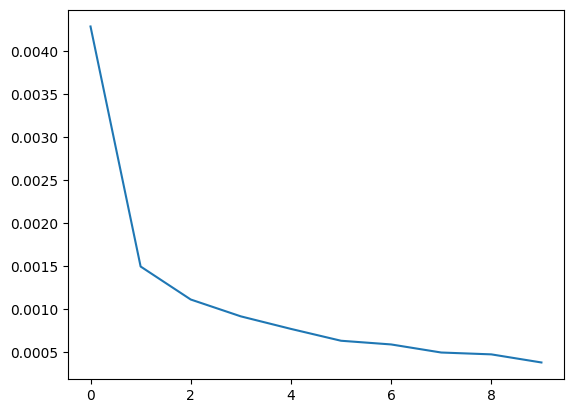

In [ ]:
# graph CNN Training Loss
with open(cnn_training_eval_filePath, 'r') as file:
    cnn_data = json.load(file)

# plots as cross entropy loss (in y) vs epochs (in x)
plt.plot(np.array(cnn_data["avg_losses_per_epoch"]))

## Train the CAE

In [ ]:
# Set model
cae_model = Conv_AE().to(device)

# Set Optimizer: Adam is the standard for MNIST and is stable and fast
cae_optimizer = optim.Adam(cae_model.parameters(), lr=1e-3)

# Train model
cae_total_losses = train_CAE(
    model=cae_model,
    dataLoader=mnist_train_dataLoader,
    optimizer = cae_optimizer,
    device=device,
    epochs=30
    )

Epoch 1/30: Loss=121.2445 
Epoch 2/30: Loss=91.8117 
Epoch 3/30: Loss=87.7872 
Epoch 4/30: Loss=85.6200 
Epoch 5/30: Loss=84.2365 
Epoch 6/30: Loss=83.2041 
Epoch 7/30: Loss=82.4482 
Epoch 8/30: Loss=81.8695 
Epoch 9/30: Loss=81.3658 
Epoch 10/30: Loss=80.9301 
Epoch 11/30: Loss=80.5956 
Epoch 12/30: Loss=80.2767 
Epoch 13/30: Loss=79.9699 
Epoch 14/30: Loss=79.7248 
Epoch 15/30: Loss=79.4718 
Epoch 16/30: Loss=79.2792 
Epoch 17/30: Loss=79.0706 
Epoch 18/30: Loss=78.9199 
Epoch 19/30: Loss=78.7346 
Epoch 20/30: Loss=78.6035 
Epoch 21/30: Loss=78.4302 
Epoch 22/30: Loss=78.3175 
Epoch 23/30: Loss=78.1872 
Epoch 24/30: Loss=78.0802 
Epoch 25/30: Loss=77.9497 
Epoch 26/30: Loss=77.8390 
Epoch 27/30: Loss=77.7365 
Epoch 28/30: Loss=77.6527 
Epoch 29/30: Loss=77.5679 
Epoch 30/30: Loss=77.4746 


In [ ]:
# Save the model
print(cae_model.state_dict().keys())
torch.save(cae_model.state_dict(), cae_filePath)

# Save training evals
cae_training_evals = {
    "model": "cae",
    "avg_losses_per_epoch": cae_total_losses
}
print(json.dumps(cae_training_evals, indent=4))

with open(cae_training_eval_filePath, "w") as f:
    json.dump(cae_training_evals, f, indent=4)


odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.2.weight', 'encoder.2.bias', 'fc_latent.weight', 'fc_latent.bias', 'fc_dec.weight', 'fc_dec.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias'])
{
    "model": "cae",
    "avg_losses_per_epoch": [
        121.24445248209635,
        91.81173474934896,
        87.78717719726562,
        85.62003326009115,
        84.2365120686849,
        83.20414536946615,
        82.44816509195964,
        81.86946071370443,
        81.36580220540364,
        80.93007182617187,
        80.59557468261718,
        80.27674593912761,
        79.96987575683593,
        79.72484959309895,
        79.47178833007813,
        79.2791501953125,
        79.07058933105469,
        78.91993234863281,
        78.73456365559896,
        78.60347542317709,
        78.43023432617187,
        78.31745013834636,
        78.187215625,
        78.0802493733724,
        77.94972676188151,
        77.83900056152343,
        77.7365056

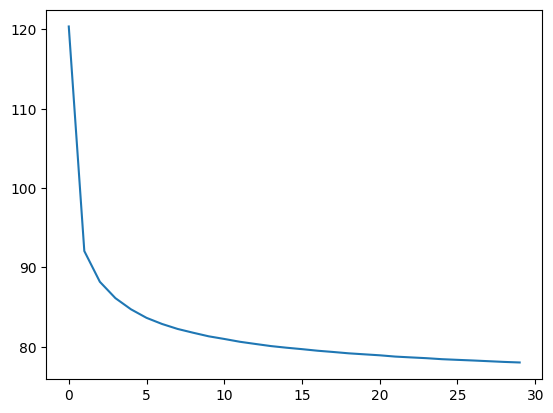

In [ ]:
# graph CAE Training Loss
with open(cae_training_eval_filePath, 'r') as file:
    cae_data = json.load(file)

# plots as MSE loss (in y) vs epochs (in x)
plt.plot(np.array(cae_data["avg_losses_per_epoch"]))

## Train the FC VAE

In [ ]:
# Set model
fcVAE_model = FC_VAE().to(device)

# Set Optimizer: Adam is the standard for MNIST and is stable and fast
fcVAE_optimizer = optim.Adam(fcVAE_model.parameters(), lr=1e-3)

# Train model
fcVAE_total_losses, fcVAE_recon_losses, fcVAE_kl_divs = train_VAE(
    model=fcVAE_model,
    dataLoader=mnist_train_dataLoader,
    optimizer = fcVAE_optimizer,
    device=device,
    beta=1.0,
    epochs=50
    )

Epoch 1/50: Loss=145.4736, Recon=130.4735, KL=15.0001
Epoch 2/50: Loss=120.3932, Recon=103.3466, KL=17.0466
Epoch 3/50: Loss=116.6594, Recon=99.1458, KL=17.5136
Epoch 4/50: Loss=114.6512, Recon=96.8131, KL=17.8381
Epoch 5/50: Loss=113.3332, Recon=95.2743, KL=18.0589
Epoch 6/50: Loss=112.3120, Recon=94.1083, KL=18.2036
Epoch 7/50: Loss=111.4860, Recon=93.1864, KL=18.2995
Epoch 8/50: Loss=110.8024, Recon=92.4224, KL=18.3800
Epoch 9/50: Loss=110.2234, Recon=91.7537, KL=18.4697
Epoch 10/50: Loss=109.7596, Recon=91.2209, KL=18.5387
Epoch 11/50: Loss=109.3087, Recon=90.7365, KL=18.5722
Epoch 12/50: Loss=108.8906, Recon=90.2516, KL=18.6390
Epoch 13/50: Loss=108.5338, Recon=89.8839, KL=18.6499
Epoch 14/50: Loss=108.2234, Recon=89.5302, KL=18.6932
Epoch 15/50: Loss=107.9414, Recon=89.2158, KL=18.7256
Epoch 16/50: Loss=107.6932, Recon=88.9163, KL=18.7769
Epoch 17/50: Loss=107.4461, Recon=88.6664, KL=18.7797
Epoch 18/50: Loss=107.2382, Recon=88.4264, KL=18.8117
Epoch 19/50: Loss=107.0663, Recon=8

In [ ]:
# Save the model
torch.save(fcVAE_model.state_dict(), fcVAE_filePath)

# Save training evals
fcVAE_training_evals = {
    "model": "fcVAE",
    "avg_losses_per_epoch": fcVAE_total_losses,
    "avg_recon_losses_per_epoch": fcVAE_recon_losses,
    "avg_kl_divs_per_epoch": fcVAE_kl_divs
}

print(json.dumps(fcVAE_training_evals, indent=4))

with open(fcVAE_training_eval_filePath, "w") as f:
    json.dump(fcVAE_training_evals, f, indent=4)

{
    "model": "fcVAE",
    "avg_losses_per_epoch": [
        145.4736071858724,
        120.39321669921875,
        116.6593774251302,
        114.65123275146485,
        113.33318301188152,
        112.31195017089844,
        111.48596533203126,
        110.8023539428711,
        110.22340517171224,
        109.75957635091146,
        109.30870112304687,
        108.89055043538411,
        108.53378740641276,
        108.22339955647786,
        107.94135055338542,
        107.6932101196289,
        107.4460981282552,
        107.23815053710938,
        107.06628679199218,
        106.8400200032552,
        106.68522222493489,
        106.52719579264323,
        106.34028838297526,
        106.22534436442058,
        106.11874575602214,
        105.95068044840495,
        105.8340623453776,
        105.75344352620442,
        105.63341407877604,
        105.53947349446615,
        105.45167863769531,
        105.36051102294923,
        105.24228484700521,
        105.15252151692708,
 

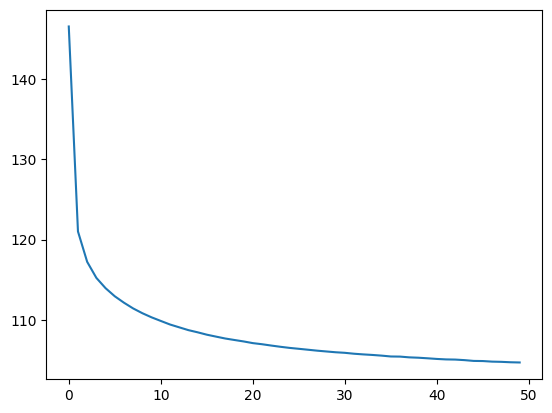

In [ ]:
# graph FC VAE Training Loss
with open(fcVAE_training_eval_filePath, 'r') as file:
    fcVAE_data = json.load(file)

# plots as ELBO loss (in y) vs epochs (in x)
plt.plot(np.array(fcVAE_data["avg_losses_per_epoch"]))

## Train the Conv VAE with Beta = 1.0

In [ ]:
# Set model
convVAE_model = Conv_VAE().to(device)

# Set Optimizer: Adam is the standard for MNIST and is stable and fast
convVAE_optimizer = optim.Adam(convVAE_model.parameters(), lr=1e-3)

# Train model
convVAE_total_losses, convVAE_recon_losses, convVAE_kl_divs = train_VAE(
    model=convVAE_model,
    dataLoader=mnist_train_dataLoader,
    optimizer = convVAE_optimizer,
    device=device,
    beta=1.0,
    epochs=50
    )

Epoch 1/50: Loss=143.4755, Recon=126.3739, KL=17.1016
Epoch 2/50: Loss=116.4585, Recon=98.0835, KL=18.3751
Epoch 3/50: Loss=112.3304, Recon=93.6452, KL=18.6852
Epoch 4/50: Loss=110.1306, Recon=91.2705, KL=18.8601
Epoch 5/50: Loss=108.7524, Recon=89.7602, KL=18.9922
Epoch 6/50: Loss=107.8004, Recon=88.7119, KL=19.0885
Epoch 7/50: Loss=107.0964, Recon=87.8998, KL=19.1966
Epoch 8/50: Loss=106.4869, Recon=87.2593, KL=19.2276
Epoch 9/50: Loss=106.0485, Recon=86.7806, KL=19.2679
Epoch 10/50: Loss=105.6848, Recon=86.3944, KL=19.2904
Epoch 11/50: Loss=105.3443, Recon=86.0263, KL=19.3180
Epoch 12/50: Loss=105.0819, Recon=85.7312, KL=19.3508
Epoch 13/50: Loss=104.8500, Recon=85.4766, KL=19.3734
Epoch 14/50: Loss=104.6039, Recon=85.2355, KL=19.3683
Epoch 15/50: Loss=104.3570, Recon=84.9962, KL=19.3609
Epoch 16/50: Loss=104.2543, Recon=84.8616, KL=19.3928
Epoch 17/50: Loss=104.0629, Recon=84.6907, KL=19.3723
Epoch 18/50: Loss=103.9112, Recon=84.5330, KL=19.3782
Epoch 19/50: Loss=103.8155, Recon=84

In [ ]:
# Save the model
torch.save(convVAE_model.state_dict(), convVAE_filePath)

# Save training evals
convVAE_training_evals = {
    "model": "convVAE",
    "avg_losses_per_epoch": convVAE_total_losses,
    "avg_recon_losses_per_epoch": convVAE_recon_losses,
    "avg_kl_divs_per_epoch": convVAE_kl_divs
}
print(json.dumps(convVAE_training_evals, indent=4))

with open(convVAE_training_eval_filePath, "w") as f:
    json.dump(convVAE_training_evals, f, indent=4)

{
    "model": "convVAE",
    "avg_losses_per_epoch": [
        143.475487882487,
        116.45850607503255,
        112.33040167236328,
        110.13057821451822,
        108.752415625,
        107.80039443359375,
        107.0963525797526,
        106.48693791910807,
        106.04854014892578,
        105.68480538736979,
        105.34434638264975,
        105.08190607096354,
        104.84998892822266,
        104.60386617431641,
        104.35703984781901,
        104.25433043212891,
        104.0629452758789,
        103.91117405598958,
        103.81550006510416,
        103.67827369384766,
        103.58218170572917,
        103.50513404541016,
        103.37041598714193,
        103.29139709472656,
        103.17063731282552,
        103.12601791178385,
        103.00906035970053,
        102.9652067220052,
        102.89535708007813,
        102.80278497721355,
        102.76109787190755,
        102.67400166829427,
        102.6477732421875,
        102.58789214680989,
   

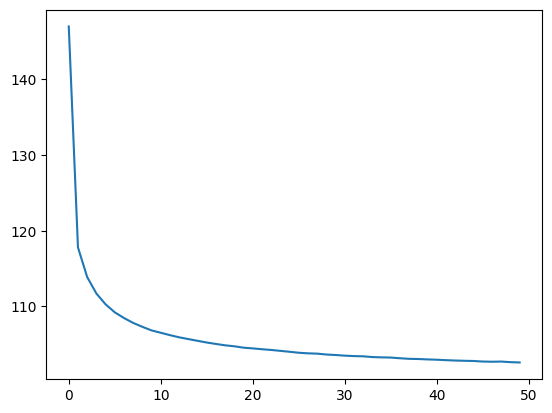

In [ ]:
# graph Conv VAE Training Loss
with open(convVAE_training_eval_filePath, 'r') as file:
    convVAE_data = json.load(file)

# plots as ELBO loss (in y) vs epochs (in x)
plt.plot(np.array(convVAE_data["avg_losses_per_epoch"]))

## Train Conv VAE with Beta = 4.0

In [ ]:
# Set model
convVAE4_model = Conv_VAE().to(device)

# Set Optimizer: Adam is the standard for MNIST and is stable and fast
convVAE4_optimizer = optim.Adam(convVAE4_model.parameters(), lr=1e-3)

# Train model
convVAE4_total_losses, convVAE4_recon_losses, convVAE4_kl_divs = train_VAE(
    model=convVAE4_model,
    dataLoader=mnist_train_dataLoader,
    optimizer = convVAE4_optimizer,
    device=device,
    beta=4.0,
    epochs=50
    )

Epoch 1/50: Loss=179.7575, Recon=151.2792, KL=7.1196
Epoch 2/50: Loss=155.4066, Recon=120.5328, KL=8.7185
Epoch 3/50: Loss=152.7170, Recon=116.5206, KL=9.0491
Epoch 4/50: Loss=151.0560, Recon=114.4016, KL=9.1636
Epoch 5/50: Loss=150.0401, Recon=113.0086, KL=9.2579
Epoch 6/50: Loss=149.3404, Recon=112.0378, KL=9.3257
Epoch 7/50: Loss=148.6899, Recon=111.3039, KL=9.3465
Epoch 8/50: Loss=148.2312, Recon=110.6519, KL=9.3948
Epoch 9/50: Loss=147.8741, Recon=110.1433, KL=9.4327
Epoch 10/50: Loss=147.5969, Recon=109.7312, KL=9.4664
Epoch 11/50: Loss=147.2201, Recon=109.2819, KL=9.4845
Epoch 12/50: Loss=146.9960, Recon=108.9427, KL=9.5133
Epoch 13/50: Loss=146.7670, Recon=108.7071, KL=9.5150
Epoch 14/50: Loss=146.7285, Recon=108.4908, KL=9.5594
Epoch 15/50: Loss=146.4325, Recon=108.2688, KL=9.5409
Epoch 16/50: Loss=146.3390, Recon=108.1022, KL=9.5592
Epoch 17/50: Loss=146.2279, Recon=107.8270, KL=9.6002
Epoch 18/50: Loss=146.1366, Recon=107.6935, KL=9.6108
Epoch 19/50: Loss=145.9465, Recon=107

In [ ]:
# Save the model
torch.save(convVAE4_model.state_dict(), convVAE4_filePath)

# Save training evals
convVAE4_training_evals = {
    "model": "convVAE4",
    "avg_losses_per_epoch": convVAE4_total_losses,
    "avg_recon_losses_per_epoch": convVAE4_recon_losses,
    "avg_kl_divs_per_epoch": convVAE4_kl_divs
}
print(json.dumps(convVAE4_training_evals, indent=4))

with open(convVAE4_training_eval_filePath, "w") as f:
    json.dump(convVAE4_training_evals, f, indent=4)

{
    "model": "convVAE4",
    "avg_losses_per_epoch": [
        179.75745857747395,
        155.40662727864583,
        152.7170195638021,
        151.05601735839844,
        150.0400795735677,
        149.3404453531901,
        148.6898573404948,
        148.23119801432293,
        147.874117195638,
        147.59688334960939,
        147.22006790364583,
        146.9960022705078,
        146.76701311035157,
        146.7284703125,
        146.43251739095052,
        146.33899318033855,
        146.22791832682293,
        146.1365719563802,
        145.94653122558594,
        145.88708095703126,
        145.77025000813802,
        145.7541168294271,
        145.6636017171224,
        145.50666806640626,
        145.5401040201823,
        145.35612346191405,
        145.3380306315104,
        145.2115747721354,
        145.27320741373697,
        145.18049200846355,
        145.10969741210937,
        145.14780317382812,
        145.0442109700521,
        145.03966708170572,
        1

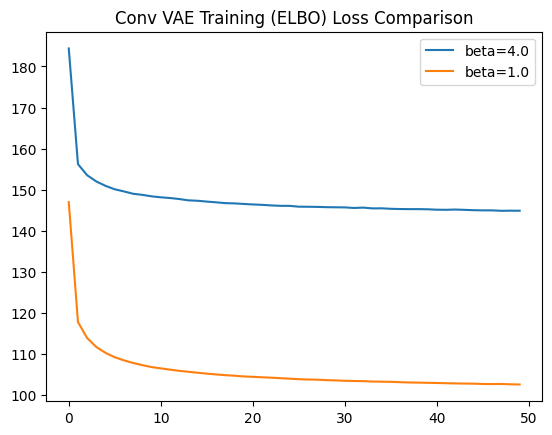

In [ ]:
# graph Conv VAE Training Loss
with open(convVAE4_training_eval_filePath, 'r') as file:
    convVAE4_data = json.load(file)

plt.plot(np.array(convVAE4_data["avg_losses_per_epoch"]), label="beta=4.0")
plt.plot(np.array(convVAE_data["avg_losses_per_epoch"]), label="beta=1.0")
plt.legend()
plt.title("Conv VAE Training (ELBO) Loss Comparison")
plt.show()

# Summary of Trained Models

* **CNN**: `cnn_model`
* **Conv_AE**: `cae_model`
* **FC_VAE**: `fcVAE_model`
* **Conv_VAE (beta = 1)**: `convVAE_model`
* **Conv_VAE (beta = 4)**: `convVAE4_model`

# Model Evaluation Functions

## Evaluation Loss Functions (Allows for Per Sample Analysis)

For the CNN, per-sample cross-entropy loss with serve as the anomaly score. For the CAE and VAEs, per-sample recon loss will serve as the anomaly score. This represents how "confused" the model is about each sample - a sample the model is confident about has low loss, while an anomalous sample typically has higher loss.

In [ ]:
# CNN evaluation loss - returns per-sample cross-entropy loss
def cnn_eval_loss(logits, labels):
  per_sample_loss = F.cross_entropy(logits, labels, reduction="none")
  return per_sample_loss

# CAE evaluation loss - returns per-sample reconstruction losses
def cae_eval_loss(input, recon):
  bce = F.binary_cross_entropy(recon, input, reduction="none")
  # Sum over pixels to get per-sample loss
  per_sample_loss = bce.view(bce.size(0), -1).sum(dim=1)
  return per_sample_loss

# VAE evaluation loss - returns per-sample recon loss and per-sample KL divergence
def vae_eval_loss(input, recon, mean, logvar, beta=1.0):
  if recon.dim() == 2:  # FC VAE flattening
    input = input.view(input.size(0), -1)

  # Per-sample reconstruction loss (sum over pixels)
  recon_bce = F.binary_cross_entropy(recon, input, reduction="none")
  per_sample_recon_loss = recon_bce.view(recon_bce.size(0), -1).sum(dim=1)

  # Per-sample KL divergence
  per_sample_kl_div = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1)

  # Per-sample ELBO
  per_sample_elbo = per_sample_recon_loss + beta * per_sample_kl_div

  return per_sample_elbo, per_sample_recon_loss, per_sample_kl_div

## CNN Classifier Eval Function

In [ ]:
def cnn_eval(model, test_dataLoader):
  model.eval()

  # metric variable initialization
  correct_preds = 0
  total = 0
  avg_loss = 0
  all_preds, all_targets = [], []
  per_sample_losses = []  # Track per-sample cross-entropy loss for ROC-AUC

  with torch.no_grad():
    total_loss = 0
    n = len(test_dataLoader.dataset)

    for x, y in test_dataLoader:
      x = x.to(device)
      y = y.to(device)
      # make classification
      logits = model(x)

      #for accuracy calcs
      preds = logits.argmax(dim=1)
      correct_preds += (preds == y).sum().item()
      total += y.size(0)
      all_preds.append(preds)
      all_targets.append(y)

      # Per-sample cross-entropy loss (anomaly score)
      sample_losses = cnn_eval_loss(logits, y)
      per_sample_losses.append(sample_losses.cpu())

      # Total loss = mean of per-sample losses
      batch_loss = sample_losses.mean()
      total_loss += batch_loss.item()

  # calculate metrics
  accuracy = round(correct_preds/total, 6)
  avg_loss = round(total_loss/n, 6)

  all_preds = torch.cat(all_preds)
  all_targets = torch.cat(all_targets)
  per_sample_losses = torch.cat(per_sample_losses, dim=0)

  print(
        f"Loss={avg_loss:.6f}, "
        f"Accuracy={accuracy:.6f} "
      )

  return accuracy, avg_loss, per_sample_losses, all_preds, all_targets


## CAE Reconstruction Eval Function

In [ ]:
# CAE evaluation - returns both average and per-sample losses
def cae_eval(model, test_dataLoader):
  model.eval()

  per_sample_losses = []  # Track per-sample reconstruction loss for ROC-AUC
  latents = []
  labels = []

  with torch.no_grad():
    for x, y in test_dataLoader:
      x = x.to(device)
      x_recon, z = model(x)

      # Get per-sample losses using eval_loss function
      sample_losses = cae_eval_loss(x, x_recon)
      per_sample_losses.append(sample_losses.cpu())

      latents.append(z.cpu())
      labels.append(y.cpu())

    # Aggregate losses
    per_sample_losses = torch.cat(per_sample_losses, dim=0)
    n = len(test_dataLoader.dataset)
    avg_recon_loss = round(per_sample_losses.sum().item() / n, 6)

  latents = torch.cat(latents, dim=0)
  labels = torch.cat(labels, dim=0)

  print(
        f"CAE Recon Loss={avg_recon_loss:.6f}"
      )

  return avg_recon_loss, per_sample_losses, latents, labels

## VAE Reconstruction Eval Function

In [ ]:
def vae_eval(model, test_dataLoader):
  model.eval()

  per_sample_elbo = []
  per_sample_recon_losses = []  # Track per-sample recon loss for ROC-AUC
  per_sample_kl_divs = []
  latents = []
  labels = []
  means = []
  logvars = []

  with torch.no_grad():
    for x, y in test_dataLoader:
      x = x.to(device)
      x_recon, mean, logvar = model(x)

      # Get per-sample losses using eval_loss function
      per_sample_elbo_batch, per_sample_recon, per_sample_kl = vae_eval_loss(x, x_recon, mean, logvar, beta=1.0)

      per_sample_elbo.append(per_sample_elbo_batch.cpu())
      per_sample_recon_losses.append(per_sample_recon.cpu())
      per_sample_kl_divs.append(per_sample_kl.cpu())

      z = model.reparam(mean, logvar)
      latents.append(z.cpu())
      labels.append(y.cpu())

      means.append(mean.cpu())
      logvars.append(logvar.cpu())

    # Aggregate losses
    per_sample_elbo = torch.cat(per_sample_elbo, dim=0)
    per_sample_recon_losses = torch.cat(per_sample_recon_losses, dim=0)
    per_sample_kl_divs = torch.cat(per_sample_kl_divs, dim=0)

    n = len(test_dataLoader.dataset)
    avg_loss = round(per_sample_elbo.sum().item() / n, 6)
    avg_recon_loss = round(per_sample_recon_losses.sum().item() / n, 6)
    avg_kl_divs = round(per_sample_kl_divs.sum().item() / n, 6)

  latents = torch.cat(latents, dim=0)
  labels = torch.cat(labels, dim=0)
  means = torch.cat(means, dim=0)
  logvars = torch.cat(logvars, dim=0)

  print(
        f"ELBO Loss={avg_loss:.6f}, "
        f"VAE Recon Loss={avg_recon_loss:.6f}, "
        f"VAE KL Divergence={avg_kl_divs:.6f}"
      )

  return avg_loss, avg_recon_loss, avg_kl_divs, per_sample_recon_losses, latents, labels, means, logvars

# Load Saved Models

In [ ]:
# in case of new/disconnected session, load trained models from saved .pth files
loaded_models = {}

models = [
    ("cnn", CNN_DigitClassifier, cnn_filePath),
    ("cae", Conv_AE, cae_filePath),
    ("fcVAE", FC_VAE, fcVAE_filePath),
    ("convVAE", Conv_VAE, convVAE_filePath),
    ("convVAE4", Conv_VAE, convVAE4_filePath),
]

for name, modelClass, model_filePath in models:
  print(model_filePath)
  model = modelClass()  # not yet on device
  state = torch.load(model_filePath, map_location=device)
  model.load_state_dict(state)
  model.to(device)
  model.eval()
  loaded_models[name] = model

cnn_model.pth
cae_model.pth
fcVAE_model.pth
convVAE_model.pth
convVAE4_model.pth


# Generate Evaluation Metrics

In [ ]:
eval_results = []
latent_results = []

testdatasets = [
    ("standard", mnist_test_data),
    ("rotated30", rotated_mnist_test_data),
    ("noisy", noisy_mnist_test_data),
    ("occluded", occluded_mnist_test_data),
    ("labelshifted0to4", labelshift_mnist_test_data),
]

for name, dataset in testdatasets:
    print(f"\n----Evaluating {name} MNIST Test Set----")

    loader = DataLoader(
      dataset,
      batch_size=batch,
      shuffle=False) # False for testing

    print("CNN Digit Classfier Model: ")
    cnn_acc, cnn_avg_loss, cnn_per_sample_loss, preds, targets = cnn_eval(loaded_models["cnn"], loader)
    eval_results.append({
        "model": "cnn",
        "dataset": name,
        "accuracy": cnn_acc,
        "avg_loss": cnn_avg_loss,
    })
    latent_results.append({
        "model": "cnn",
        "dataset": name,
        "per_sample_recon_loss": cnn_per_sample_loss,
        "preds": preds,
        "labels": targets
    })

    print("CAE Model: ")
    cae_recon, cae_per_sample_recon, cae_latents, cae_labels = cae_eval(loaded_models["cae"], loader)
    eval_results.append({
        "model": "cae",
        "dataset": name,
        "recon_loss": cae_recon
    })
    latent_results.append({
        "model": "cae",
        "dataset": name,
        "per_sample_recon_loss": cae_per_sample_recon,
        "latents": cae_latents,
        "labels": cae_labels
    })

    print("FC VAE Model: ")
    fcvae_elbo, fcvae_recon, fcvae_kl, fcvae_per_sample_recon, fcvae_latents, fcvae_labels, fcvae_means, fcvae_logvars = vae_eval(loaded_models["fcVAE"], loader)
    eval_results.append({
        "model": "fcVAE",
        "dataset": name,
        "elbo_loss": fcvae_elbo,
        "recon_loss": fcvae_recon,
        "kl_div": fcvae_kl
    })
    latent_results.append({
        "model": "fcVAE",
        "dataset": name,
        "per_sample_recon_loss": fcvae_per_sample_recon,
        "latents": fcvae_latents,
        "labels": fcvae_labels,
        'means': fcvae_means,
        'logvars': fcvae_logvars
    })

    print("Conv VAE Model (Beta = 1): ")
    cvae_elbo, cvae_recon, cvae_kl, cvae_per_sample_recon, cvae_latents, cvae_labels, cvae_means, cvae_logvars = vae_eval(loaded_models["convVAE"], loader)
    eval_results.append({
        "model": "convVAE",
        "dataset": name,
        "elbo_loss": cvae_elbo,
        "recon_loss": cvae_recon,
        "kl_div": cvae_kl
    })
    latent_results.append({
        "model": "convVAE",
        "dataset": name,
        "per_sample_recon_loss": cvae_per_sample_recon,
        "latents": cvae_latents,
        "labels": cvae_labels,
        'means': cvae_means,
        'logvars': cvae_logvars
    })
    print("Conv VAE Model (Beta = 4): ")
    cvae4_elbo, cvae4_recon, cvae4_kl, cvae4_per_sample_recon, cvae4_latents, cvae4_labels, cvae4_means, cvae4_logvars = vae_eval(loaded_models["convVAE4"], loader)
    eval_results.append({
        "model": "convVAE4",
        "dataset": name,
        "elbo_loss": cvae4_elbo,
        "recon_loss": cvae4_recon,
        "kl_div": cvae4_kl
    })
    latent_results.append({
        "model": "convVAE4",
        "dataset": name,
        "per_sample_recon_loss": cvae4_per_sample_recon,
        "latents": cvae4_latents,
        "labels": cvae4_labels,
        'means': cvae4_means,
        'logvars': cvae4_logvars
    })


----Evaluating standard MNIST Test Set----
CNN Digit Classfier Model: 
Loss=0.000325, Accuracy=0.994300 
CAE Model: 
CAE Recon Loss=78.570650
FC VAE Model: 
ELBO Loss=106.128613, VAE Recon Loss=87.449138, VAE KL Divergence=18.679480
Conv VAE Model (Beta = 1): 
ELBO Loss=103.155762, VAE Recon Loss=83.665444, VAE KL Divergence=19.490316
Conv VAE Model (Beta = 4): 
ELBO Loss=116.406963, VAE Recon Loss=107.082850, VAE KL Divergence=9.324109

----Evaluating rotated30 MNIST Test Set----
CNN Digit Classfier Model: 
Loss=0.003414, Accuracy=0.950800 
CAE Model: 
CAE Recon Loss=105.875250
FC VAE Model: 
ELBO Loss=133.652887, VAE Recon Loss=115.098800, VAE KL Divergence=18.554084
Conv VAE Model (Beta = 1): 
ELBO Loss=128.451375, VAE Recon Loss=108.883863, VAE KL Divergence=19.567497
Conv VAE Model (Beta = 4): 
ELBO Loss=138.820075, VAE Recon Loss=129.372062, VAE KL Divergence=9.448016

----Evaluating noisy MNIST Test Set----
CNN Digit Classfier Model: 
Loss=0.000538, Accuracy=0.989300 
CAE Model

In [ ]:
with open(shifted_eval_filePath, "w") as f:
    json.dump(eval_results, f, indent=4)

torch.save(latent_results, latent_eval_filePath)


# Load Saved Evaluation Data

In [ ]:
# Load eval data
with open(shifted_eval_filePath, 'r') as file:
    eval_data = json.load(file)

df = pd.DataFrame(eval_data)

print(df.head(20))

# Latent data
latent_results = torch.load(latent_eval_filePath, map_location='cpu')

       model    dataset  accuracy  avg_loss  recon_loss   elbo_loss     kl_div
0        cnn   standard    0.9943  0.000325         NaN         NaN        NaN
1        cae   standard       NaN       NaN   78.570650         NaN        NaN
2      fcVAE   standard       NaN       NaN   87.449138  106.128613  18.679480
3    convVAE   standard       NaN       NaN   83.665444  103.155762  19.490316
4   convVAE4   standard       NaN       NaN  107.082850  116.406963   9.324109
5        cnn  rotated30    0.9508  0.003414         NaN         NaN        NaN
6        cae  rotated30       NaN       NaN  105.875250         NaN        NaN
7      fcVAE  rotated30       NaN       NaN  115.098800  133.652887  18.554084
8    convVAE  rotated30       NaN       NaN  108.883863  128.451375  19.567497
9   convVAE4  rotated30       NaN       NaN  129.372062  138.820075   9.448016
10       cnn      noisy    0.9893  0.000538         NaN         NaN        NaN
11       cae      noisy       NaN       NaN  626.520

# Plot Average Accuracy/Recon Loss Changes Across Datasets

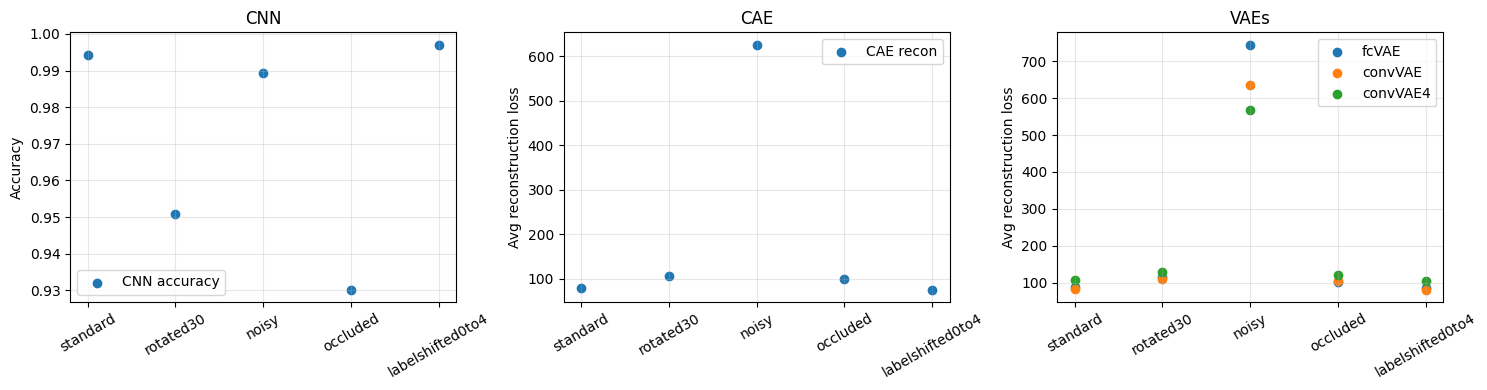

In [ ]:
# Define an order for the datasets
shift_order = ["standard", "rotated30", "noisy", "occluded", "labelshifted0to4"]

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

# 1) CNN: accuracy vs shift
cnn_df = df[df["model"] == "cnn"].set_index("dataset").loc[shift_order]
axes[0].scatter(cnn_df.index, cnn_df["accuracy"], marker="o", label="CNN accuracy")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("CNN")
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[0].tick_params(axis="x", rotation=30)

# 2) CAE: reconstruction loss vs shift
cae_df = df[df["model"] == "cae"].set_index("dataset").loc[shift_order]
axes[1].scatter(cae_df.index, cae_df["recon_loss"], marker="o", label="CAE recon")
axes[1].set_ylabel("Avg reconstruction loss")
axes[1].set_title("CAE")
axes[1].grid(True, alpha=0.3)
axes[1].legend()
axes[1].tick_params(axis="x", rotation=30)

# 3) VAEs: reconstruction loss vs shift
for m in ["fcVAE", "convVAE", "convVAE4"]:
    mdf = df[df["model"] == m].set_index("dataset").loc[shift_order]
    axes[2].scatter(mdf.index, mdf["recon_loss"], marker="o", label=m)

axes[2].set_ylabel("Avg reconstruction loss")
axes[2].set_title("VAEs")
axes[2].grid(True, alpha=0.3)
axes[2].legend()
axes[2].tick_params(axis="x", rotation=30)

plt.tight_layout()
plt.show()

# Comparison of Conv VAEs with Different Betas


BETA COMPARISON: Convolutional VAE (Beta=1.0 vs Beta=4.0)

STANDARD:
Metric               Beta=1.0        Beta=4.0        Difference     
-----------------------------------------------------------------
ELBO Loss            103.155762      116.406963      +13.251201
Recon Loss           83.665444       107.082850      +23.417406
KL Divergence        19.490316       9.324109        -10.166207

ROTATED30:
Metric               Beta=1.0        Beta=4.0        Difference     
-----------------------------------------------------------------
ELBO Loss            128.451375      138.820075      +10.368700
Recon Loss           108.883863      129.372062      +20.488199
KL Divergence        19.567497       9.448016        -10.119481

NOISY:
Metric               Beta=1.0        Beta=4.0        Difference     
-----------------------------------------------------------------
ELBO Loss            655.790950      578.732300      -77.058650
Recon Loss           636.307550      568.519550      -67.

/tmp/ipython-input-1782169346.py:47: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  axes[0].plot(testdatasets, [d['beta1_elbo'] for d in comparison_data], 'o-', label='Beta=1.0', linestyle='None', markersize=8)
/tmp/ipython-input-1782169346.py:48: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
  axes[0].plot(testdatasets, [d['beta4_elbo'] for d in comparison_data], 's-', label='Beta=4.0', linestyle='None', markersize=8)
/tmp/ipython-input-1782169346.py:56: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  axes[1].plot(testdatasets, [d['beta1_recon'] for d in comparison_data], 'o-', label='Beta=1.0', linestyle='None', markersi

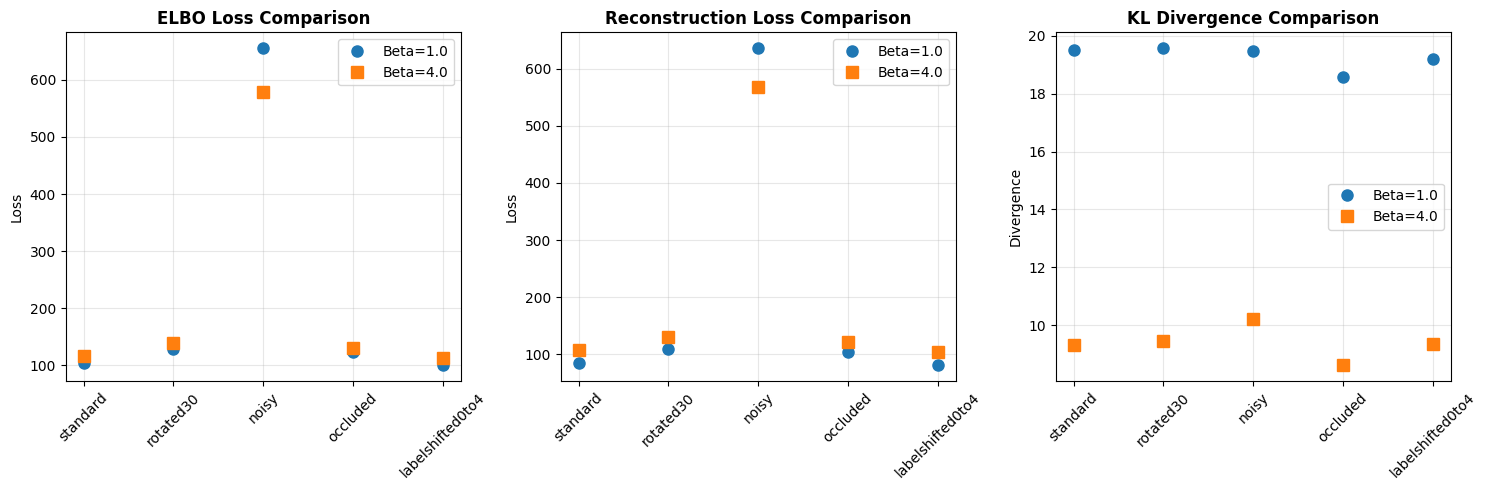


Key Observations:
- Beta=1.0 prioritizes reconstruction quality (generally lower recon loss)
- Beta=4.0 prioritizes latent regularization (lower KL divergence)
- ELBO loss combines both effects with different weights


In [ ]:
# Compare beta=1.0 vs beta=4.0 across all metrics and datasets
print("\n" + "="*80)
print("BETA COMPARISON: Convolutional VAE (Beta=1.0 vs Beta=4.0)")
print("="*80)

comparison_data = []

for dataset_name in ["standard", "rotated30", "noisy", "occluded", "labelshifted0to4"]:
    beta1_entry = [e for e in eval_results if e['model'] == 'convVAE' and e['dataset'] == dataset_name]
    beta4_entry = [e for e in eval_results if e['model'] == 'convVAE4' and e['dataset'] == dataset_name]

    if beta1_entry and beta4_entry:
        beta1 = beta1_entry[0]
        beta4 = beta4_entry[0]

        print(f"\n{dataset_name.upper()}:")
        print(f"{'Metric':<20} {'Beta=1.0':<15} {'Beta=4.0':<15} {'Difference':<15}")
        print("-" * 65)

        # ELBO Loss
        elbo_diff = beta4['elbo_loss'] - beta1['elbo_loss']
        print(f"{'ELBO Loss':<20} {beta1['elbo_loss']:<15.6f} {beta4['elbo_loss']:<15.6f} {elbo_diff:+.6f}")

        # Reconstruction Loss
        recon_diff = beta4['recon_loss'] - beta1['recon_loss']
        print(f"{'Recon Loss':<20} {beta1['recon_loss']:<15.6f} {beta4['recon_loss']:<15.6f} {recon_diff:+.6f}")

        # KL Divergence
        kl_diff = beta4['kl_div'] - beta1['kl_div']
        print(f"{'KL Divergence':<20} {beta1['kl_div']:<15.6f} {beta4['kl_div']:<15.6f} {kl_diff:+.6f}")

        comparison_data.append({
            'dataset': dataset_name,
            'beta1_elbo': beta1['elbo_loss'],
            'beta4_elbo': beta4['elbo_loss'],
            'beta1_recon': beta1['recon_loss'],
            'beta4_recon': beta4['recon_loss'],
            'beta1_kl': beta1['kl_div'],
            'beta4_kl': beta4['kl_div']
        })

# Visualize the comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
testdatasets = [d['dataset'] for d in comparison_data]

# ELBO Loss
axes[0].plot(testdatasets, [d['beta1_elbo'] for d in comparison_data], 'o-', label='Beta=1.0', linestyle='None', markersize=8)
axes[0].plot(testdatasets, [d['beta4_elbo'] for d in comparison_data], 's-', label='Beta=4.0', linestyle='None', markersize=8)
axes[0].set_title('ELBO Loss Comparison', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Reconstruction Loss
axes[1].plot(testdatasets, [d['beta1_recon'] for d in comparison_data], 'o-', label='Beta=1.0', linestyle='None', markersize=8)
axes[1].plot(testdatasets, [d['beta4_recon'] for d in comparison_data], 's-', label='Beta=4.0', linestyle='None', markersize=8)
axes[1].set_title('Reconstruction Loss Comparison', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

# KL Divergence
axes[2].plot(testdatasets, [d['beta1_kl'] for d in comparison_data], 'o-', label='Beta=1.0', linestyle='None', markersize=8)
axes[2].plot(testdatasets, [d['beta4_kl'] for d in comparison_data], 's-', label='Beta=4.0', linestyle='None', markersize=8)
axes[2].set_title('KL Divergence Comparison', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Divergence')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Key Observations:")
print("="*80)
print("- Beta=1.0 prioritizes reconstruction quality (generally lower recon loss)")
print("- Beta=4.0 prioritizes latent regularization (lower KL divergence)")
print("- ELBO loss combines both effects with different weights")

# Latent Uncertainty Analysis



Latent Space Uncertainty Analysis
   Model     Split  Digit  Count  Mean_Latent_Variance  Std_Latent_Variance  \
0  fcVAE  standard      0    980              0.025985             0.014780   
1  fcVAE  standard      1   1135              0.085843             0.078462   
2  fcVAE  standard      2   1032              0.024143             0.014404   
3  fcVAE  standard      3   1010              0.025751             0.017140   
4  fcVAE  standard      4    982              0.029888             0.016270   
5  fcVAE  standard      5    892              0.028442             0.016840   
6  fcVAE  standard      6    958              0.029601             0.018146   
7  fcVAE  standard      7   1028              0.034733             0.022093   
8  fcVAE  standard      8    974              0.025077             0.015176   
9  fcVAE  standard      9   1009              0.030151             0.017105   

   Mean_Latent_Std  Std_Latent_Std  Min_Latent_Variance  Max_Latent_Variance  
0         0.1548

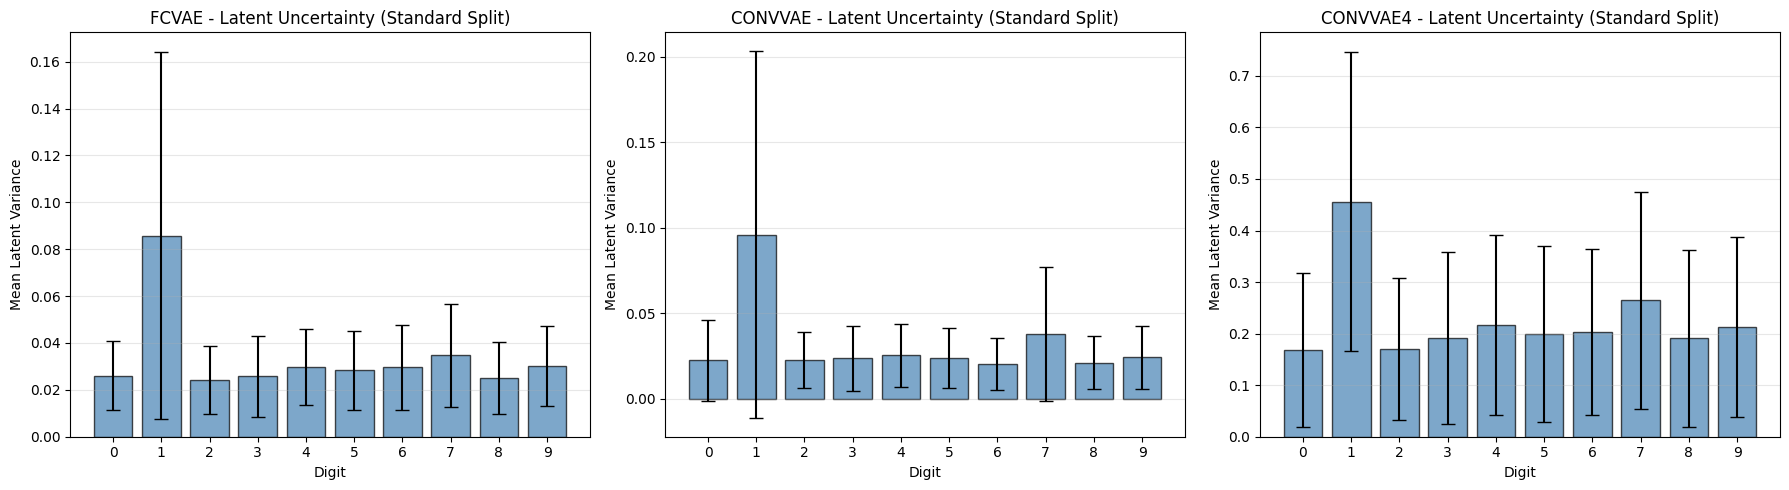

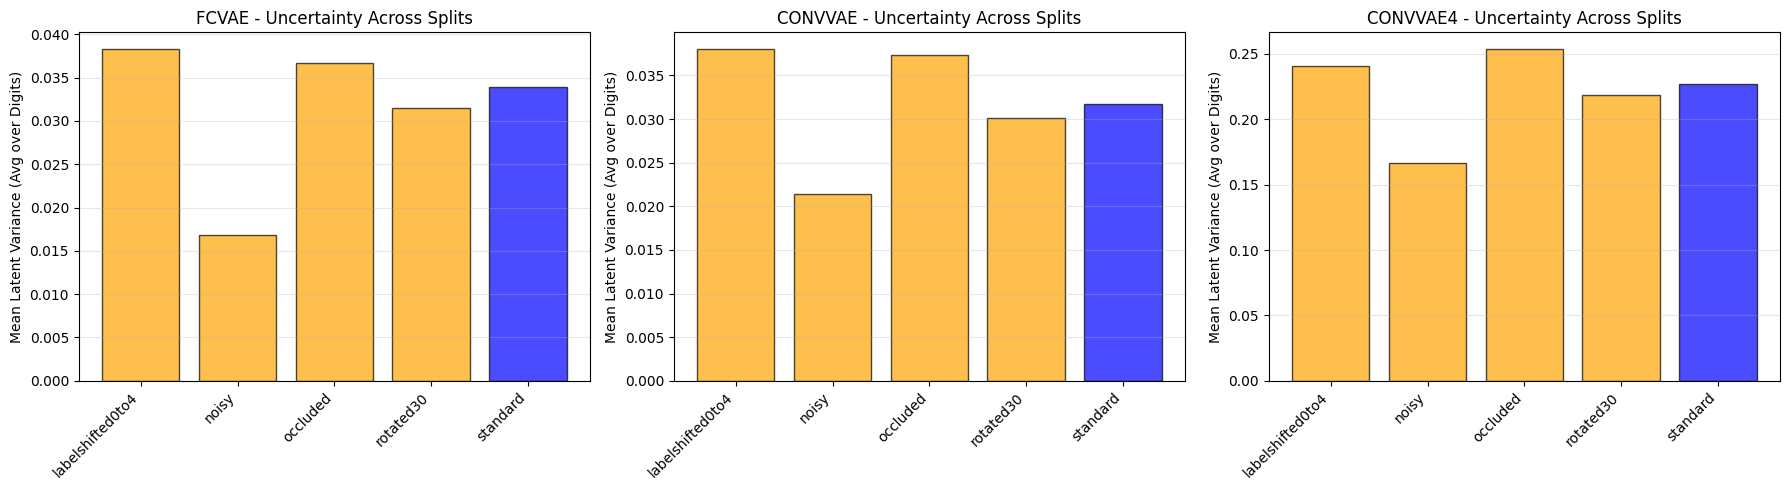

In [ ]:
# Calculate latent uncertainty metrics (aleatoric uncertainty in latent space)
print(f"\n{'='*80}")
print("Latent Space Uncertainty Analysis")
print(f"{'='*80}")

uncertainty_records = []

# Only VAE models have latent uncertainty (they output mean and logvar)
vae_models = ['fcVAE', 'convVAE', 'convVAE4']

for result in latent_results:
    model = result['model']
    split = result['dataset']

    # VAE models have logvar (log variance) in the latent space
    if model in vae_models and 'logvars' in result:
        logvar = result['logvars'].numpy()
        # Convert log variance to actual variance
        variance = np.exp(logvar)
        std_dev = np.sqrt(variance)

        # Calculate per-digit uncertainty
        labels = result['labels'].numpy()

        for digit in range(10):
            digit_mask = labels == digit
            if digit_mask.sum() > 0:
                digit_variances = variance[digit_mask]
                digit_stds = std_dev[digit_mask]

                uncertainty_records.append({
                    'Model': model,
                    'Split': split,
                    'Digit': digit,
                    'Count': digit_mask.sum(),
                    'Mean_Latent_Variance': digit_variances.mean(),
                    'Std_Latent_Variance': digit_variances.std(),
                    'Mean_Latent_Std': digit_stds.mean(),
                    'Std_Latent_Std': digit_stds.std(),
                    'Min_Latent_Variance': digit_variances.min(),
                    'Max_Latent_Variance': digit_variances.max(),
                })

# Create DataFrame for uncertainty analysis
df_latent_uncertainty = pd.DataFrame(uncertainty_records)

print(df_latent_uncertainty.head(10))

# Print summary
print("\nLatent Space Uncertainty Summary by Model and Split:")
print("="*80)

for model in vae_models:
    print(f"\n{model.upper()}:")
    model_df = df_latent_uncertainty[df_latent_uncertainty['Model'] == model]

    for split in sorted(model_df['Split'].unique()):
        split_df = model_df[model_df['Split'] == split]
        print(f"\n  {split.upper()}:")
        print(f"  {'Digit':<10} {'Mean Var':<15} {'Std Var':<15} {'Mean Std':<15}")
        print("  " + "-" * 55)

        for _, row in split_df.iterrows():
            digit = int(row['Digit'])
            mean_var = row['Mean_Latent_Variance']
            std_var = row['Std_Latent_Variance']
            mean_std = row['Mean_Latent_Std']
            print(f"  {digit:<10} {mean_var:<15.4f} {std_var:<15.4f} {mean_std:<15.4f}")

        # Overall for split
        overall_mean_var = split_df['Mean_Latent_Variance'].mean()
        overall_std_var = split_df['Mean_Latent_Variance'].std()
        overall_mean_std = split_df['Mean_Latent_Std'].mean()
        print("  " + "-" * 55)
        print(f"  {'OVERALL':<10} {overall_mean_var:<15.4f} {overall_std_var:<15.4f} {overall_mean_std:<15.4f}")

# Visualization 1: Latent uncertainty comparison across models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for plot_idx, model in enumerate(vae_models):
    ax = axes[plot_idx]
    model_df = df_latent_uncertainty[df_latent_uncertainty['Model'] == model]

    # Get data for standard split
    standard_df = model_df[model_df['Split'] == 'standard']

    digits = standard_df['Digit'].values
    mean_vars = standard_df['Mean_Latent_Variance'].values
    std_vars = standard_df['Std_Latent_Variance'].values

    # Bar plot with error bars
    ax.bar(digits, mean_vars, yerr=std_vars, alpha=0.7, capsize=5, color='steelblue', edgecolor='black')
    ax.set_xlabel('Digit')
    ax.set_ylabel('Mean Latent Variance')
    ax.set_title(f'{model.upper()} - Latent Uncertainty (Standard Split)')
    ax.set_xticks(range(10))
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Visualization 2: Latent uncertainty change across perturbations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for plot_idx, model in enumerate(vae_models):
    ax = axes[plot_idx]
    model_df = df_latent_uncertainty[df_latent_uncertainty['Model'] == model]

    # Calculate overall uncertainty (averaged across all digits) for each split
    split_uncertainty = model_df.groupby('Split')['Mean_Latent_Variance'].mean()

    splits = list(split_uncertainty.index)
    uncertainties = list(split_uncertainty.values)

    colors = ['blue' if d == 'standard' else 'orange' for d in splits]
    ax.bar(range(len(splits)), uncertainties, color=colors, alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(splits)))
    ax.set_xticklabels(splits, rotation=45, ha='right')
    ax.set_ylabel('Mean Latent Variance (Avg over Digits)')
    ax.set_title(f'{model.upper()} - Uncertainty Across Splits')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


# ROC-AUC

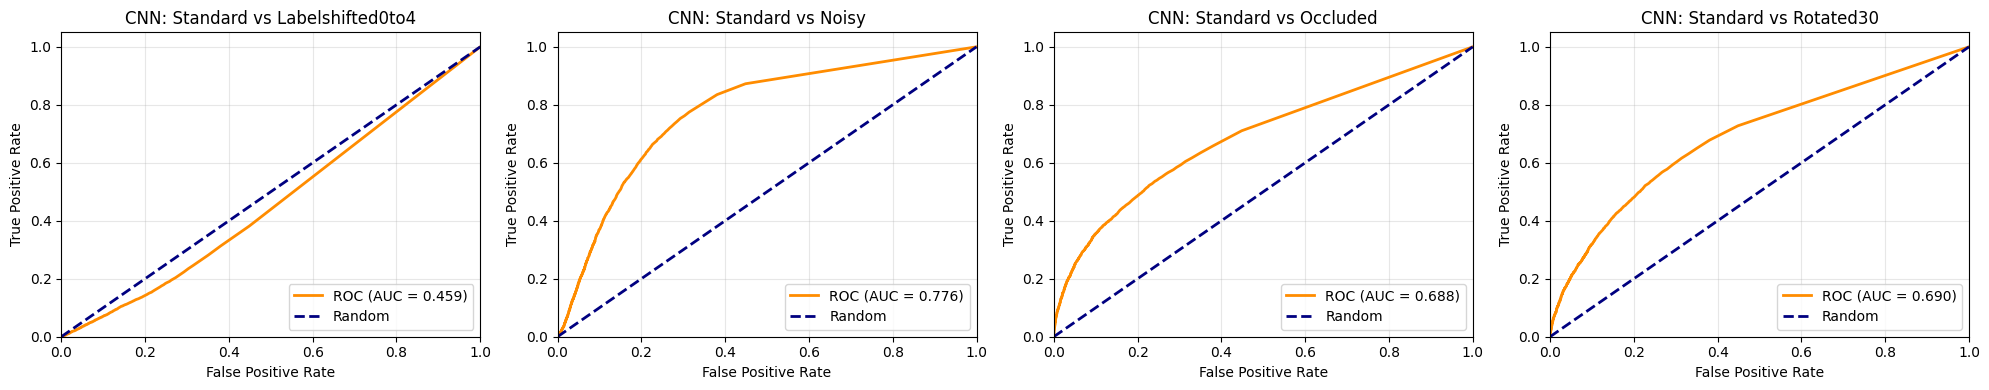

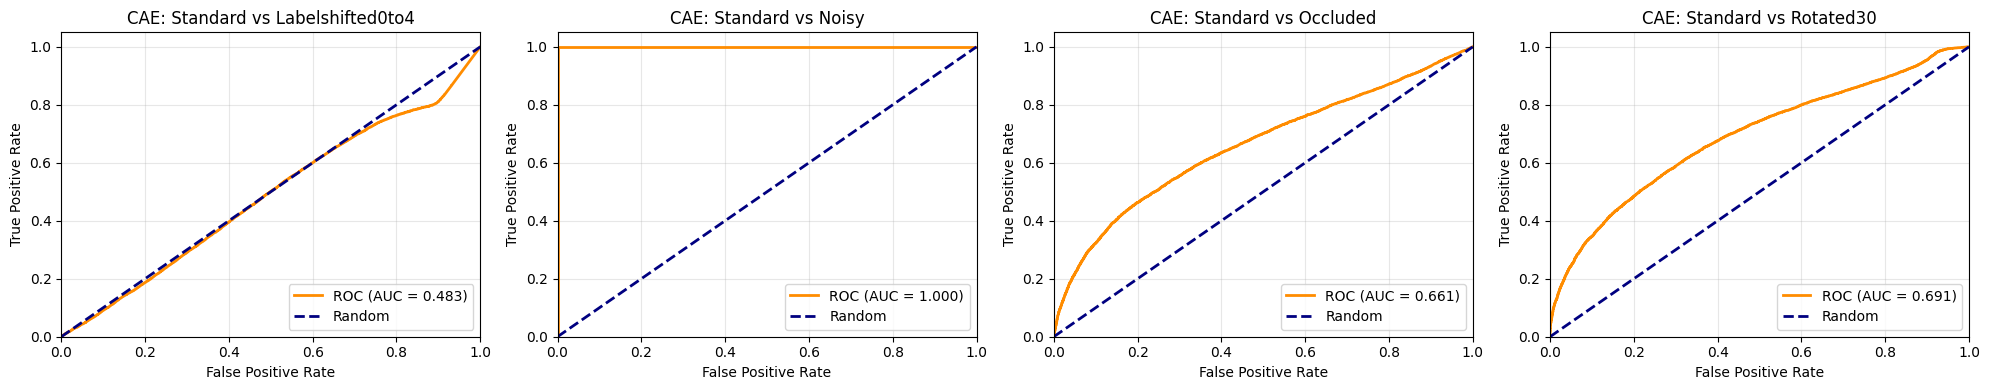

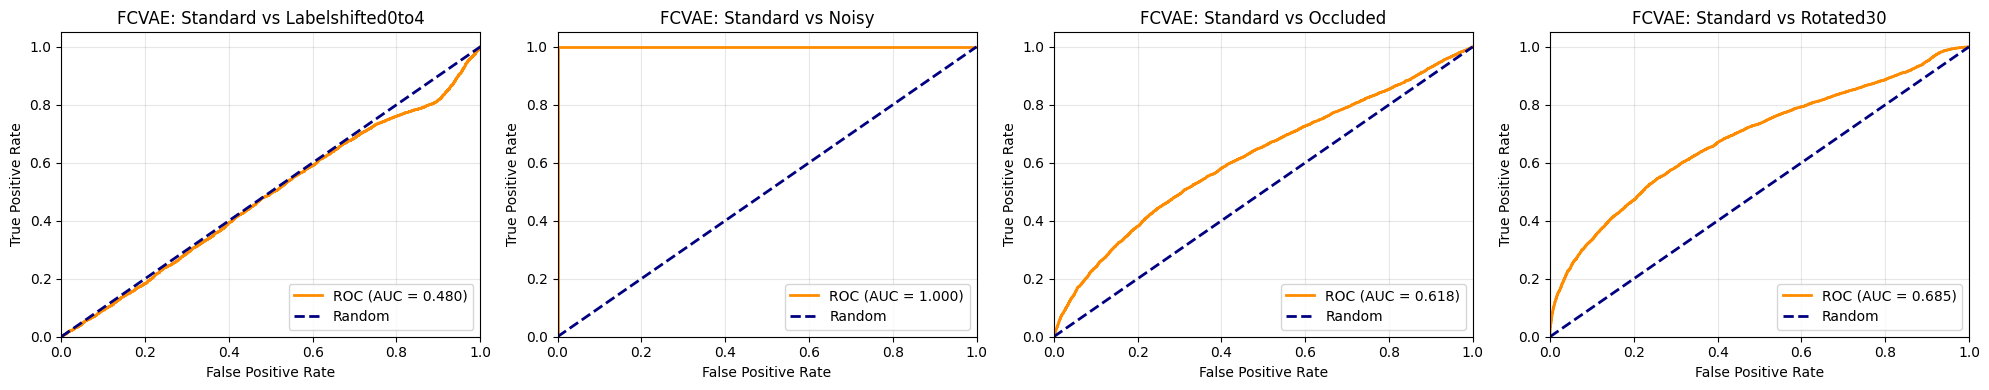

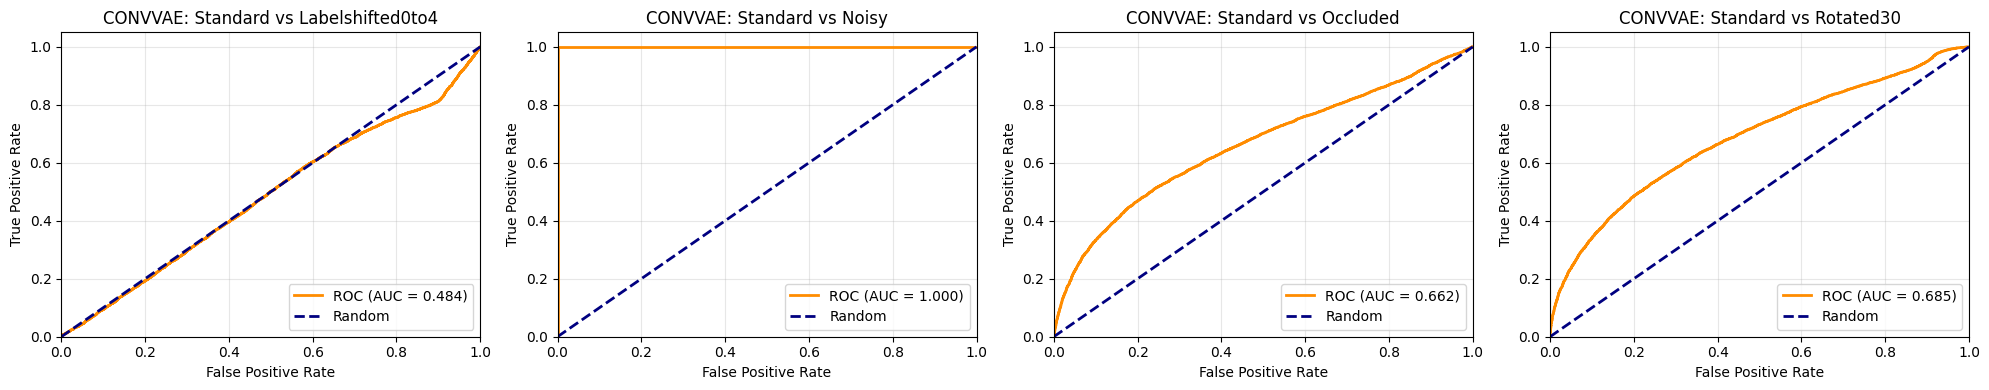

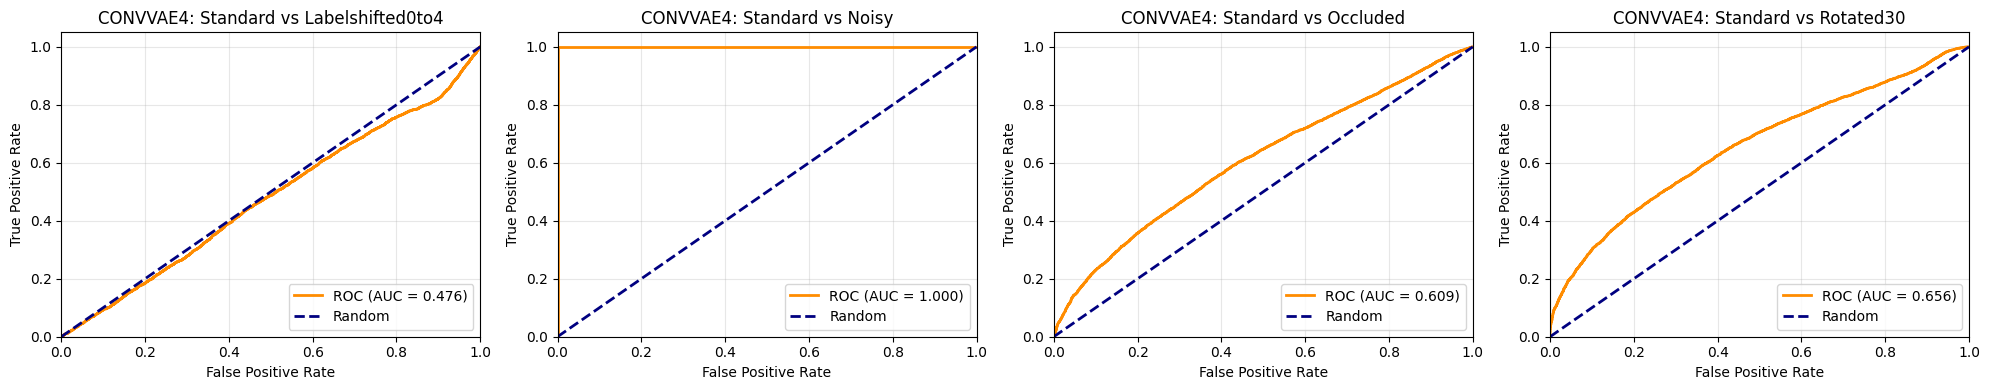


=== ROC-AUC Summary ===

CNN:
  labelshifted0to4: AUC = 0.4591
  noisy: AUC = 0.7763
  occluded: AUC = 0.6880
  rotated30: AUC = 0.6903

CAE:
  labelshifted0to4: AUC = 0.4831
  noisy: AUC = 1.0000
  occluded: AUC = 0.6613
  rotated30: AUC = 0.6911

FCVAE:
  labelshifted0to4: AUC = 0.4804
  noisy: AUC = 1.0000
  occluded: AUC = 0.6183
  rotated30: AUC = 0.6851

CONVVAE:
  labelshifted0to4: AUC = 0.4837
  noisy: AUC = 1.0000
  occluded: AUC = 0.6619
  rotated30: AUC = 0.6851

CONVVAE4:
  labelshifted0to4: AUC = 0.4765
  noisy: AUC = 1.0000
  occluded: AUC = 0.6090
  rotated30: AUC = 0.6557


In [ ]:
# Get unique models and datasets
models = ['cnn', 'cae', 'fcVAE', 'convVAE', 'convVAE4']
testdatasets = sorted(set(e['dataset'] for e in latent_results))
shifted_datasets = [d for d in testdatasets if d != 'standard']

# Dictionary to store results
roc_results = {}

# Loop through each model
for model in models:
    roc_results[model] = {}

    # Get standard dataset entry for this model
    standard_entries = [e for e in latent_results if e['model'] == model and e['dataset'] == 'standard']
    if not standard_entries:
        print(f"Warning: No standard dataset for {model}")
        continue

    standard_entry = standard_entries[0]
    standard_scores = standard_entry['per_sample_recon_loss'].numpy()

    # Create subplots for each model (one row, multiple columns for each shifted dataset)
    fig, axes = plt.subplots(1, len(shifted_datasets), figsize=(5*len(shifted_datasets), 4))
    if len(shifted_datasets) == 1:
        axes = [axes]

    # Loop through each shifted dataset
    for idx, shifted in enumerate(shifted_datasets):
        shifted_entries = [e for e in latent_results if e['model'] == model and e['dataset'] == shifted]
        if not shifted_entries:
            print(f"Warning: No {shifted} dataset for {model}")
            continue

        shifted_entry = shifted_entries[0]
        shifted_scores = shifted_entry['per_sample_recon_loss'].numpy()

        # Create binary labels (0 = standard/normal, 1 = shifted/anomaly)
        y_true = np.concatenate([np.zeros(len(standard_scores)),
                                np.ones(len(shifted_scores))])
        scores = np.concatenate([standard_scores, shifted_scores])

        # Calculate ROC-AUC
        roc_auc = roc_auc_score(y_true, scores)
        fpr, tpr, _ = roc_curve(y_true, scores)

        # Store results
        roc_results[model][shifted] = {'auc': roc_auc, 'fpr': fpr, 'tpr': tpr}

        # Plot
        ax = axes[idx]
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'{model.upper()}: Standard vs {shifted.capitalize()}')
        ax.legend(loc="lower right")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Print summary
print("\n=== ROC-AUC Summary ===")
for model in roc_results:
    print(f"\n{model.upper()}:")
    for dataset, metrics in roc_results[model].items():
        print(f"  {dataset}: AUC = {metrics['auc']:.4f}")

## Noisy AUC of 1.0 Diagnostics

In [ ]:
# Diagnostic: Check noisy dataset reconstruction loss distribution
print("=== Noisy Dataset Diagnosis ===\n")

for model in models:
    print(f"\n{model.upper()}:")

    # Get standard and noisy entries
    standard_entries = [e for e in latent_results if e['model'] == model and e['dataset'] == 'standard']
    noisy_entries = [e for e in latent_results if e['model'] == model and e['dataset'] == 'noisy']

    if not standard_entries or not noisy_entries:
        print(f"  Missing data for {model}")
        continue

    standard_losses = standard_entries[0]['per_sample_recon_loss'].numpy()
    noisy_losses = noisy_entries[0]['per_sample_recon_loss'].numpy()

    print(f"  Standard losses: min={standard_losses.min():.4f}, max={standard_losses.max():.4f}, mean={standard_losses.mean():.4f}")
    print(f"  Noisy losses:    min={noisy_losses.min():.4f}, max={noisy_losses.max():.4f}, mean={noisy_losses.mean():.4f}")
    print(f"  Overlap: {(standard_losses.max() >= noisy_losses.min())}")
    print(f"  Min noisy > Max standard: {noisy_losses.min() > standard_losses.max()}")


=== Noisy Dataset Diagnosis ===


CNN:
  Standard losses: min=-0.0000, max=10.9484, mean=0.0208
  Noisy losses:    min=-0.0000, max=9.7917, mean=0.0344
  Overlap: True
  Min noisy > Max standard: False

CAE:
  Standard losses: min=14.0531, max=274.1418, mean=78.5706
  Noisy losses:    min=437.8318, max=876.0846, mean=626.5201
  Overlap: False
  Min noisy > Max standard: True

FCVAE:
  Standard losses: min=19.1524, max=288.1236, mean=87.4491
  Noisy losses:    min=494.4955, max=1292.2483, mean=745.3755
  Overlap: False
  Min noisy > Max standard: True

CONVVAE:
  Standard losses: min=20.2143, max=274.4968, mean=83.6655
  Noisy losses:    min=469.3132, max=852.0607, mean=636.3076
  Overlap: False
  Min noisy > Max standard: True

CONVVAE4:
  Standard losses: min=27.8554, max=268.0329, mean=107.0828
  Noisy losses:    min=436.4349, max=745.1124, mean=568.5195
  Overlap: False
  Min noisy > Max standard: True


# Reconstruction Visualizations

In [ ]:
# Define a reusable function for reconstruction visualization
def visualize_reconstructions(shifted_dataset, dataset_label, num_samples=10):
    """
    Visualize reconstructions comparing standard vs shifted dataset for all models.

    Args:
        shifted_dataset: The shifted dataset to compare against standard
        dataset_label: Display name for the shifted dataset (e.g., 'Noisy', 'Rotated')
        num_samples: Number of image samples to display (default: 10)
    """
    print(f"\n=== Reconstruction Visualization: Standard vs {dataset_label} ===")

    # Get batches
    standard_loader = DataLoader(mnist_test_data, batch_size=num_samples, shuffle=False)
    shifted_loader = DataLoader(shifted_dataset, batch_size=num_samples, shuffle=False)

    x_standard, _ = next(iter(standard_loader))
    x_shifted, _ = next(iter(shifted_loader))

    x_standard = x_standard.to(device)
    x_shifted = x_shifted.to(device)

    # Models to visualize
    model_configs = [
      ('cae', loaded_models["cae"], cae_eval_loss, False),  # (name, model, loss_fn, is_fc)
      ('fcvae', loaded_models["fcVAE"], vae_eval_loss, True),
      ('convvae', loaded_models["convVAE"], vae_eval_loss, False),
      ('convvae4', loaded_models["convVAE4"], vae_eval_loss, False),
    ]

    for model_name, model, loss_fn, is_fc in model_configs:
        model.eval()

        # Prepare input for FC models
        x_std_input = x_standard.view(x_standard.size(0), -1) if is_fc else x_standard
        x_shifted_input = x_shifted.view(x_shifted.size(0), -1) if is_fc else x_shifted

        with torch.no_grad():
            if model_name == 'cae':
                recon_std, _ = model(x_standard)
                recon_shifted, _ = model(x_shifted)
                std_losses = cae_eval_loss(x_standard, recon_std).cpu().numpy()
                shifted_losses = cae_eval_loss(x_shifted, recon_shifted).cpu().numpy()
            else:  # VAE models
                recon_std, mean_std, logvar_std = model(x_std_input)
                recon_shifted, mean_shifted, logvar_shifted = model(x_shifted_input)
                _, std_losses, _ = vae_eval_loss(x_std_input, recon_std, mean_std, logvar_std)
                _, shifted_losses, _ = vae_eval_loss(x_shifted_input, recon_shifted, mean_shifted, logvar_shifted)
                std_losses = std_losses.cpu().numpy()
                shifted_losses = shifted_losses.cpu().numpy()

        # Unflatten reconstructions for FC models for visualization
        if is_fc:
            recon_std = recon_std.view(recon_std.size(0), 1, 28, 28)
            recon_shifted = recon_shifted.view(recon_shifted.size(0), 1, 28, 28)

        print(f"\n{model_name.upper()} Reconstruction Losses:")
        print(f"  Standard images: {std_losses}")
        print(f"  {dataset_label} images: {shifted_losses}")
        print(f"  Mean difference: {shifted_losses.mean() - std_losses.mean():.2f}")

        # Plot reconstructions
        fig, axes = plt.subplots(3, num_samples, figsize=(15, 5))

        for i in range(num_samples):
            # Standard
            axes[0, i].imshow(x_standard[i].cpu().squeeze(), cmap='gray')
            axes[0, i].set_title(f'Clean\nLoss: {std_losses[i]:.1f}', fontsize=8)
            axes[0, i].axis('off')

            # Shifted
            axes[1, i].imshow(x_shifted[i].cpu().squeeze(), cmap='gray')
            axes[1, i].set_title(f'{dataset_label}\nLoss: {shifted_losses[i]:.1f}', fontsize=8)
            axes[1, i].axis('off')

            # Reconstruction of shifted
            axes[2, i].imshow(recon_shifted[i].cpu().squeeze(), cmap='gray')
            axes[2, i].set_title(f'Recon\nLoss: {shifted_losses[i]:.1f}', fontsize=8)
            axes[2, i].axis('off')

        plt.suptitle(f'{model_name.upper()}: Standard vs {dataset_label} Images and Reconstructions', fontsize=12)
        plt.tight_layout()
        plt.show()


=== Reconstruction Visualization: Standard vs Noisy ===

CAE Reconstruction Losses:
  Standard images: [ 53.85579   78.62864   28.50621   73.13276   67.00745   28.064362
  99.0674    85.85861  157.40686   79.11806 ]
  Noisy images: [676.1457  721.6028  553.1245  601.2247  691.73914 551.89075 673.8584
 602.7728  659.7207  640.12756]
  Mean difference: 562.16


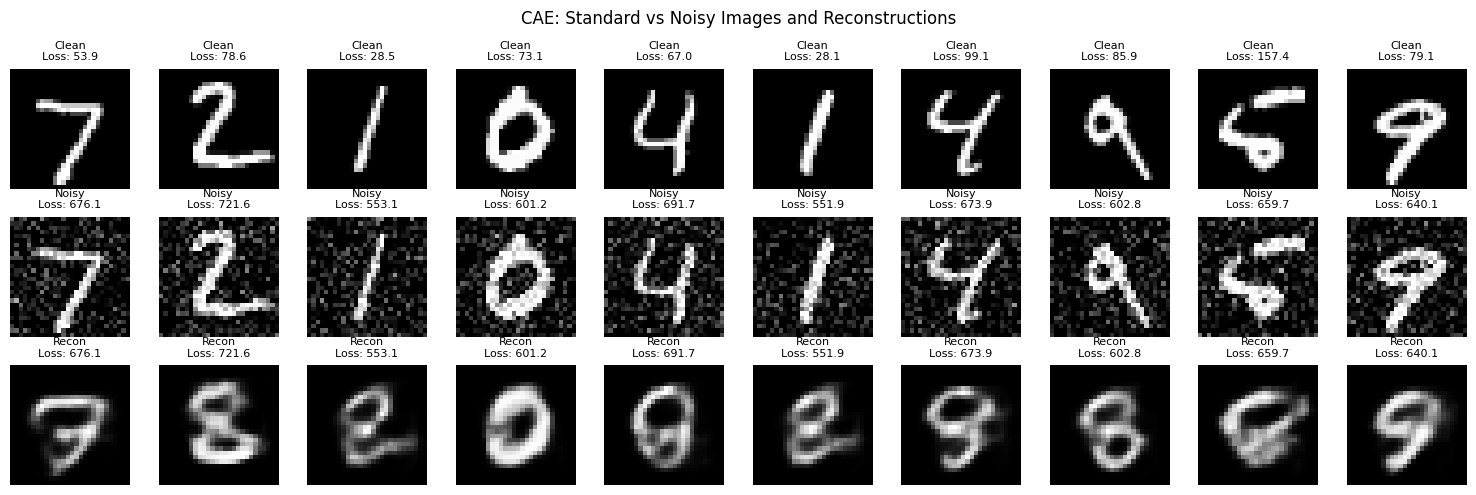


FCVAE Reconstruction Losses:
  Standard images: [ 60.185562  89.92496   33.1798    87.77228   81.26038   32.507267
 107.44909  116.34205  204.98434   91.62046 ]
  Noisy images: [ 680.5186  1038.5278   627.738    740.1322   763.4894   631.15894
  728.08856  604.8821   904.6115   674.23035]
  Mean difference: 648.82


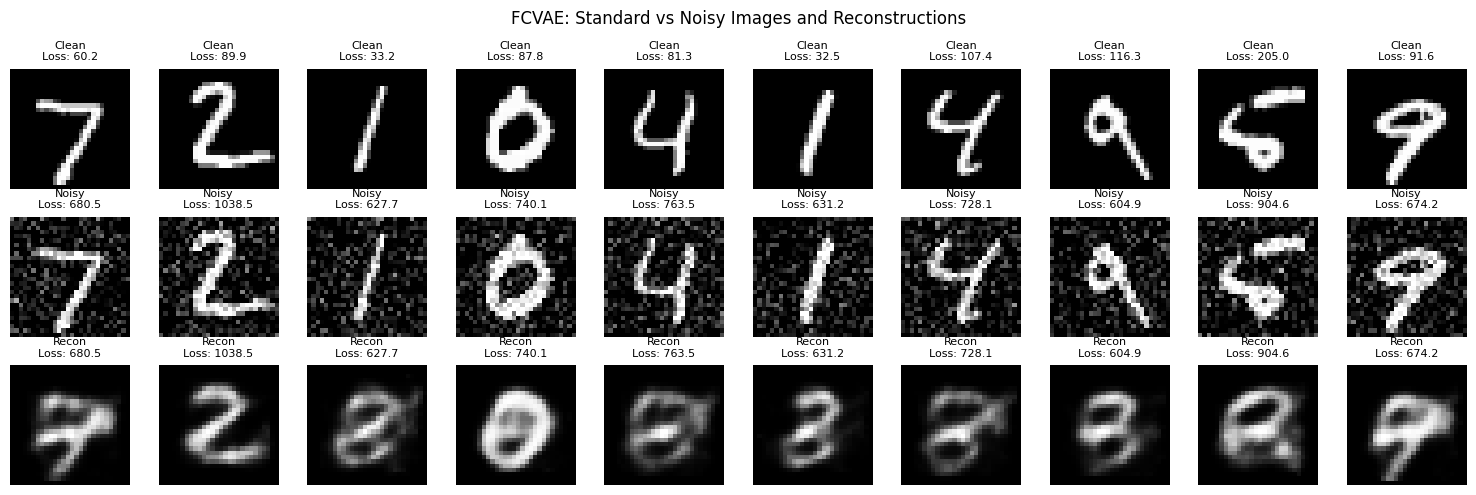


CONVVAE Reconstruction Losses:
  Standard images: [ 58.804016  90.576416  32.07216   85.83909   79.62236   27.939232
  98.29137   82.43768  157.30122   80.3897  ]
  Noisy images: [688.99866 786.4219  614.3093  610.3685  704.3613  620.38794 727.9463
 618.60333 703.5888  612.234  ]
  Mean difference: 589.39


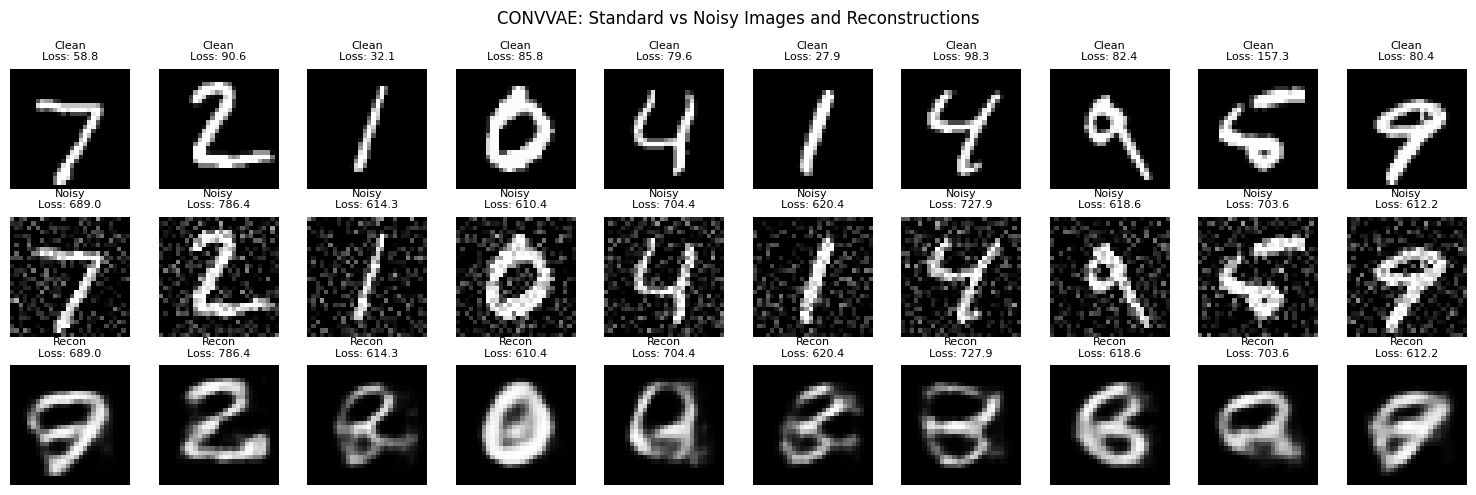


CONVVAE4 Reconstruction Losses:
  Standard images: [ 81.41109  105.921135  60.10466   95.6006   104.06024   64.71999
 146.17859  109.62257  166.85611  140.62042 ]
  Noisy images: [569.5272  676.3682  560.4259  547.7994  597.06226 562.4248  608.8453
 545.35675 605.37964 589.8115 ]
  Mean difference: 478.79


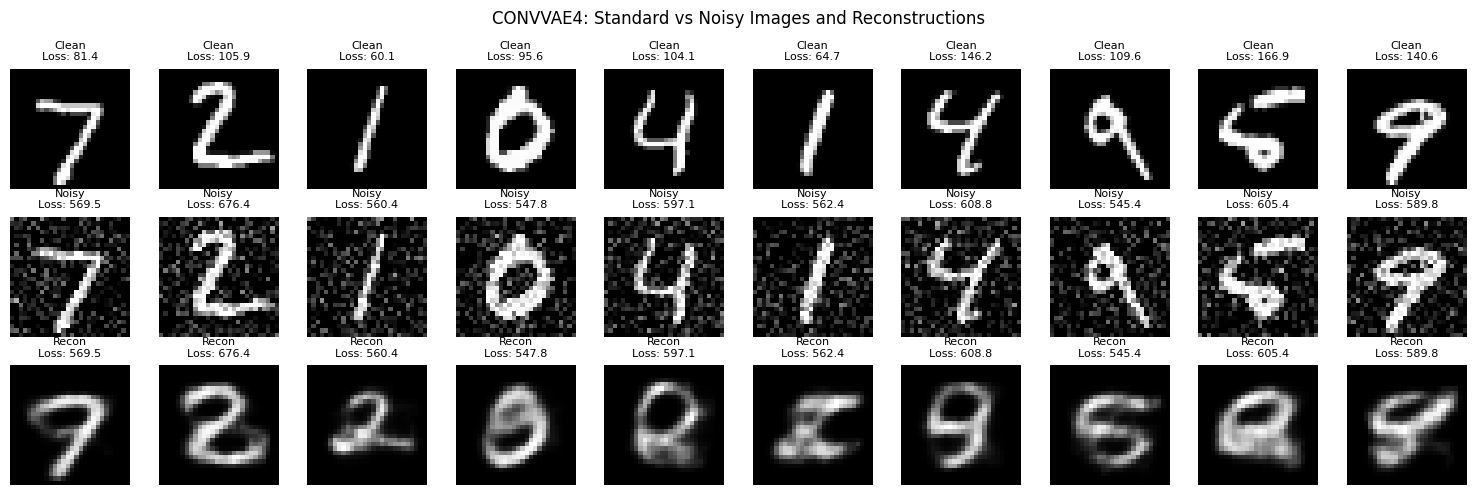

In [ ]:
# Visualize each shifted dataset reconstruction
visualize_reconstructions(noisy_mnist_test_data, 'Noisy')


=== Reconstruction Visualization: Standard vs Rotated ===

CAE Reconstruction Losses:
  Standard images: [ 53.85579   78.62864   28.50621   73.13276   67.00745   28.064362
  99.0674    85.85861  157.40686   79.118065]
  Rotated images: [ 75.07587  137.77367   42.23529   73.13276   88.21253   38.61507
  97.8933   129.3042   147.27734  105.250885]
  Mean difference: 18.41


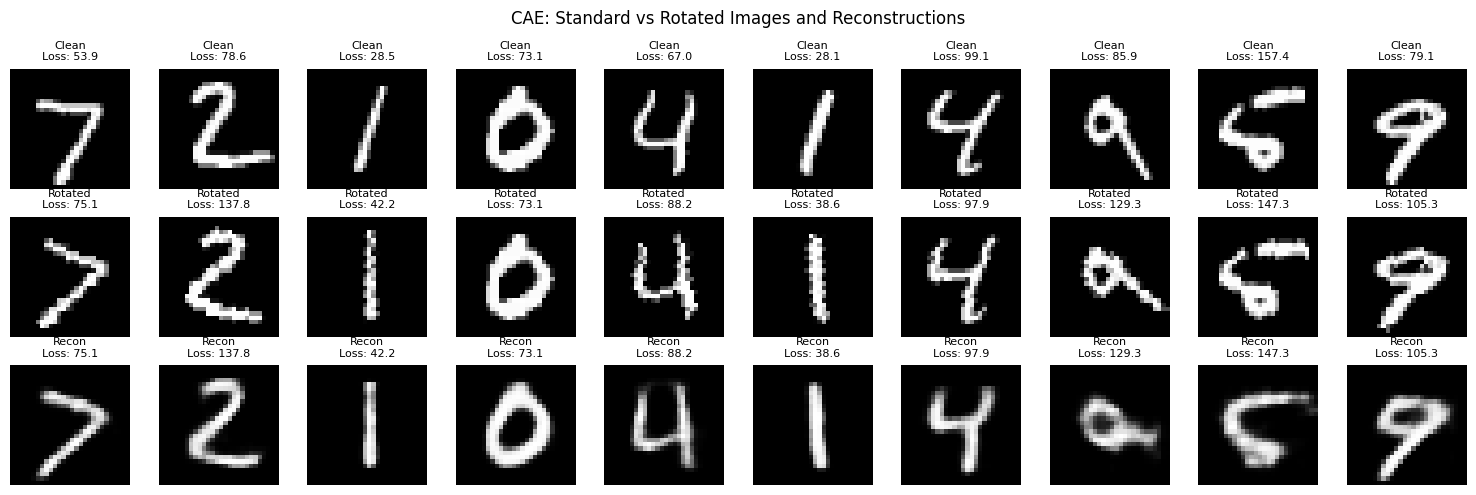


FCVAE Reconstruction Losses:
  Standard images: [ 60.20703   86.45772   33.514935  85.684494  69.465256  32.16998
 108.9187   112.65146  172.08427  101.07293 ]
  Rotated images: [ 89.95215  171.48605   45.062904  86.7144    96.40193   41.033073
 113.68936  189.06607  142.7122   127.01073 ]
  Mean difference: 24.09


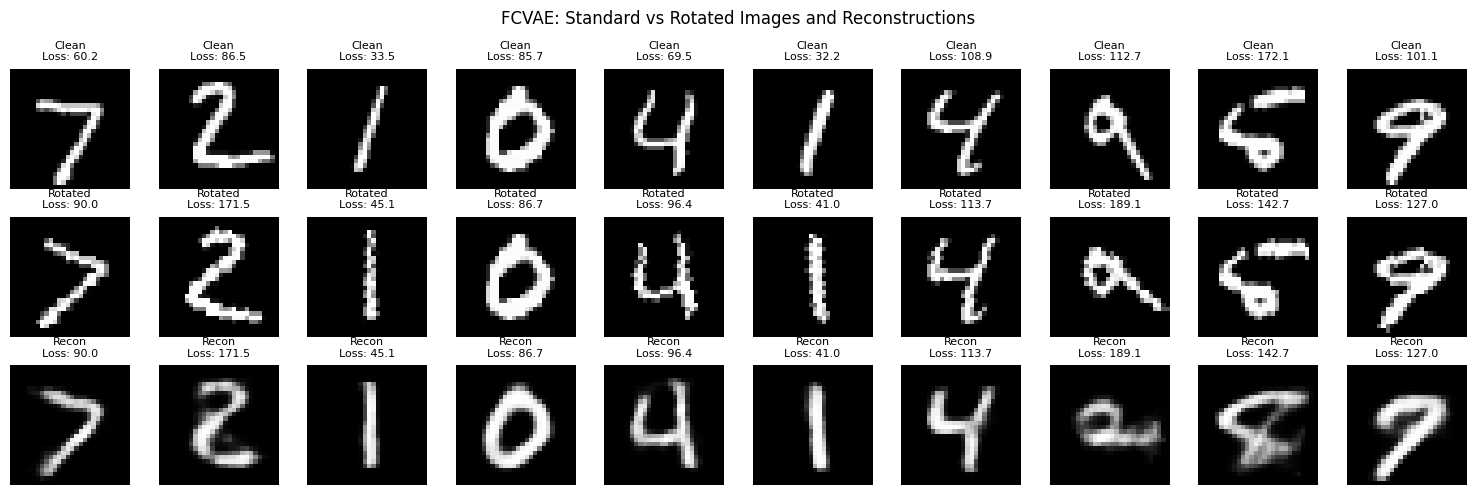


CONVVAE Reconstruction Losses:
  Standard images: [ 65.41281   92.7652    30.965     81.517624  68.445564  34.065807
 102.04423   84.39556  138.4509    85.2206  ]
  Rotated images: [ 87.2636   131.99345   39.885567  76.9348    96.560555  42.13299
 104.22269  169.36554  136.66577  103.212616]
  Mean difference: 20.50


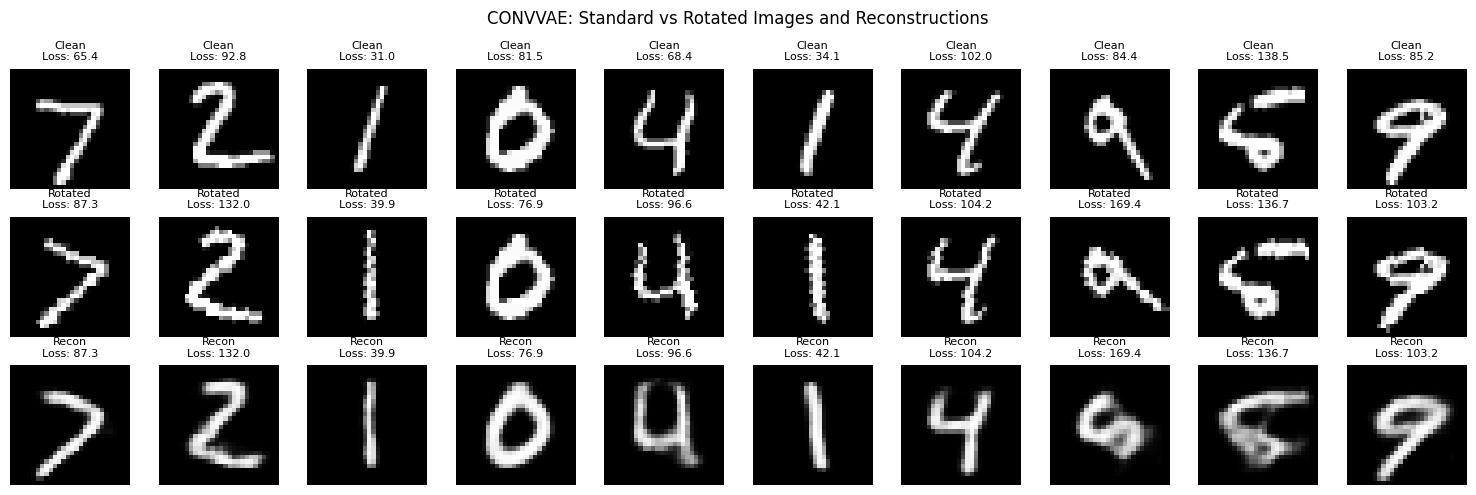


CONVVAE4 Reconstruction Losses:
  Standard images: [ 70.21147  102.018715  38.556053  92.75531   98.37494   44.13404
 127.9481   135.04654  149.98233  111.3295  ]
  Rotated images: [103.61664  212.55907   60.322098  99.863014 139.18152   45.75055
 144.1243   154.06639  189.46307  145.31389 ]
  Mean difference: 32.39


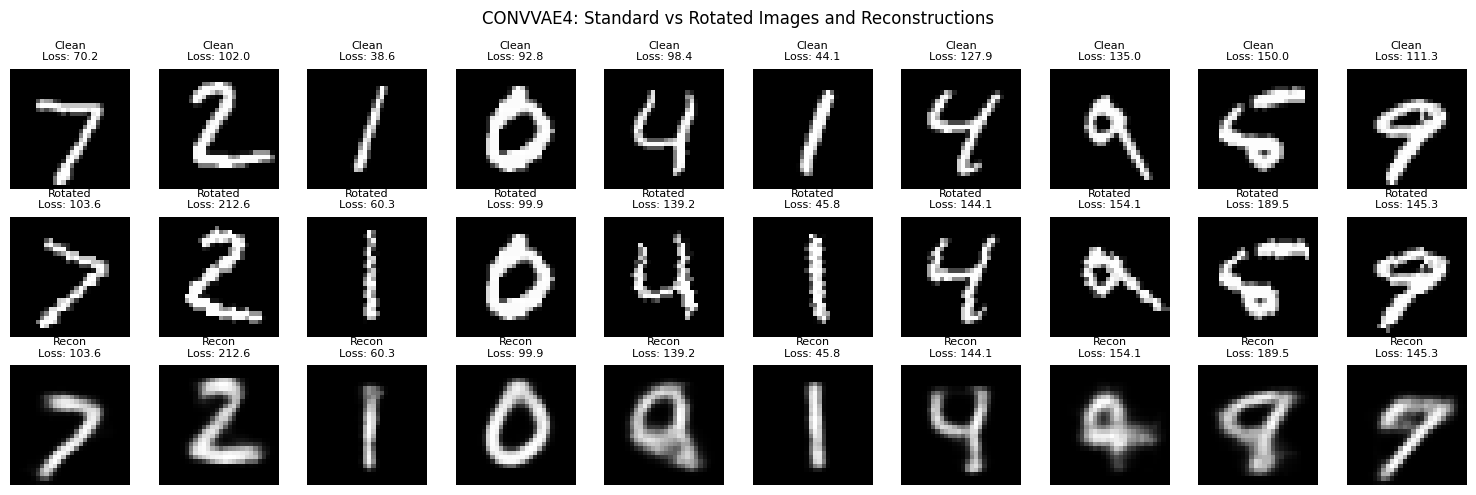

In [ ]:
visualize_reconstructions(rotated_mnist_test_data, 'Rotated')


=== Reconstruction Visualization: Standard vs Label Shifted ===

CAE Reconstruction Losses:
  Standard images: [ 53.85579   78.62864   28.50621   73.13276   67.00745   28.064362
  99.0674    85.85861  157.40686   79.118065]
  Label Shifted images: [ 78.62864   28.50621   73.13276   67.00745   28.064362  99.0674
  76.71335   71.454834  28.56855  129.08412 ]
  Mean difference: -7.04


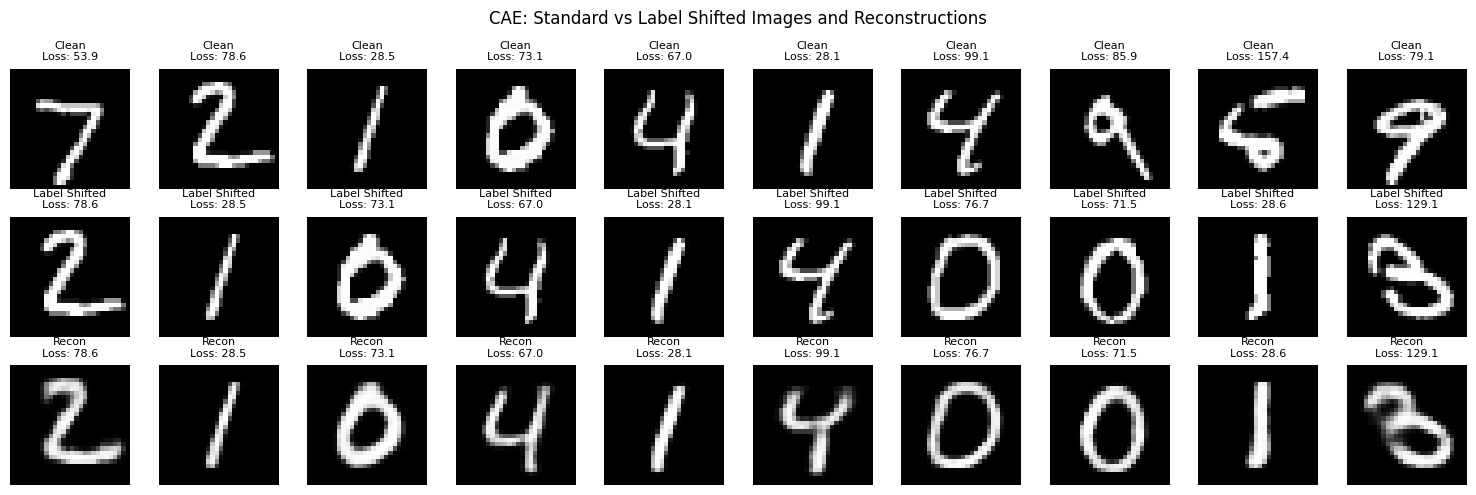


FCVAE Reconstruction Losses:
  Standard images: [ 57.951744  87.196014  36.851273  85.57558   70.94386   32.84281
 106.127525 115.751434 160.96552  102.4659  ]
  Label Shifted images: [ 87.62389   32.298557  91.714676  69.29333   32.802414 108.02041
  87.85683   76.592766  37.526314 128.91682 ]
  Mean difference: -10.40


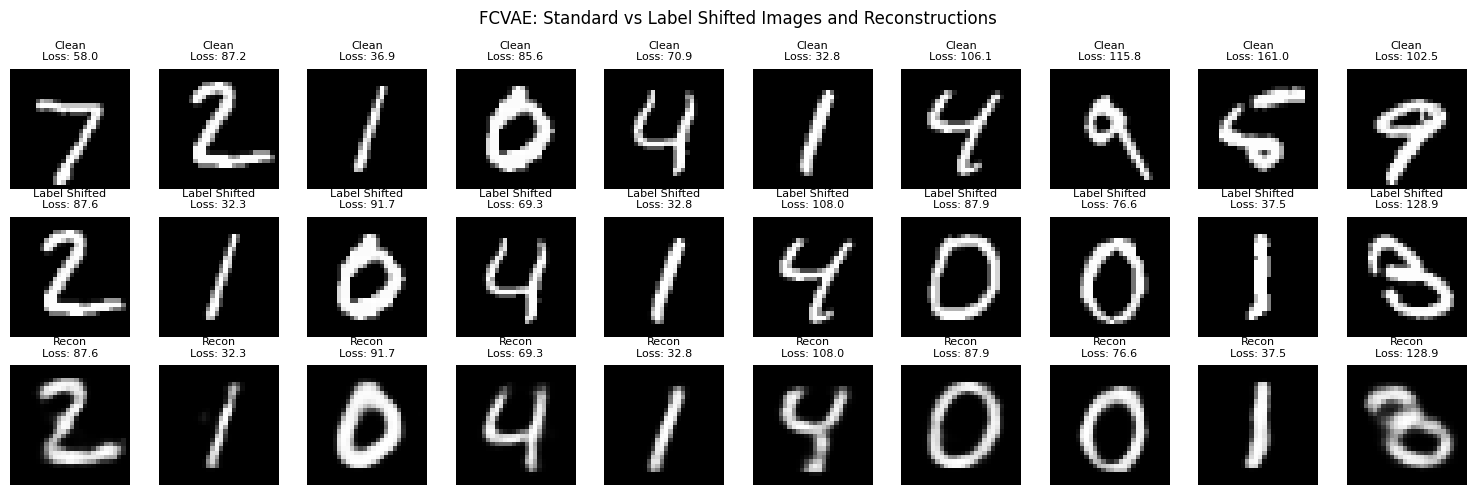


CONVVAE Reconstruction Losses:
  Standard images: [ 60.836037  94.00754   32.516983  82.763824  73.19281   35.6402
 114.69534   81.33273  144.02835   80.20488 ]
  Label Shifted images: [ 93.148865  32.380585  81.142365  76.74366   30.919884 100.89743
  80.855194  78.83381   31.845495 140.67294 ]
  Mean difference: -5.18


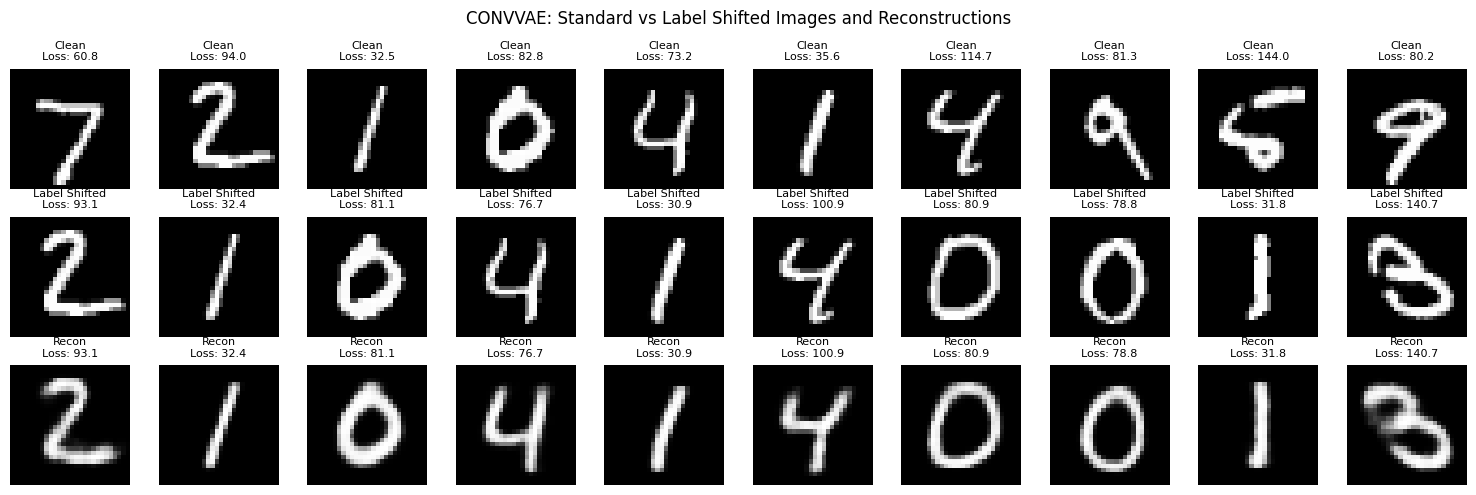


CONVVAE4 Reconstruction Losses:
  Standard images: [ 65.70447  136.04367   43.74559  116.07919   75.712296  32.821526
 132.49661  141.00986  161.3616   101.081055]
  Label Shifted images: [131.83499   60.653175  93.46414   82.33786   37.5483   127.16097
  92.8721    88.01552   42.384094 141.95499 ]
  Mean difference: -10.78


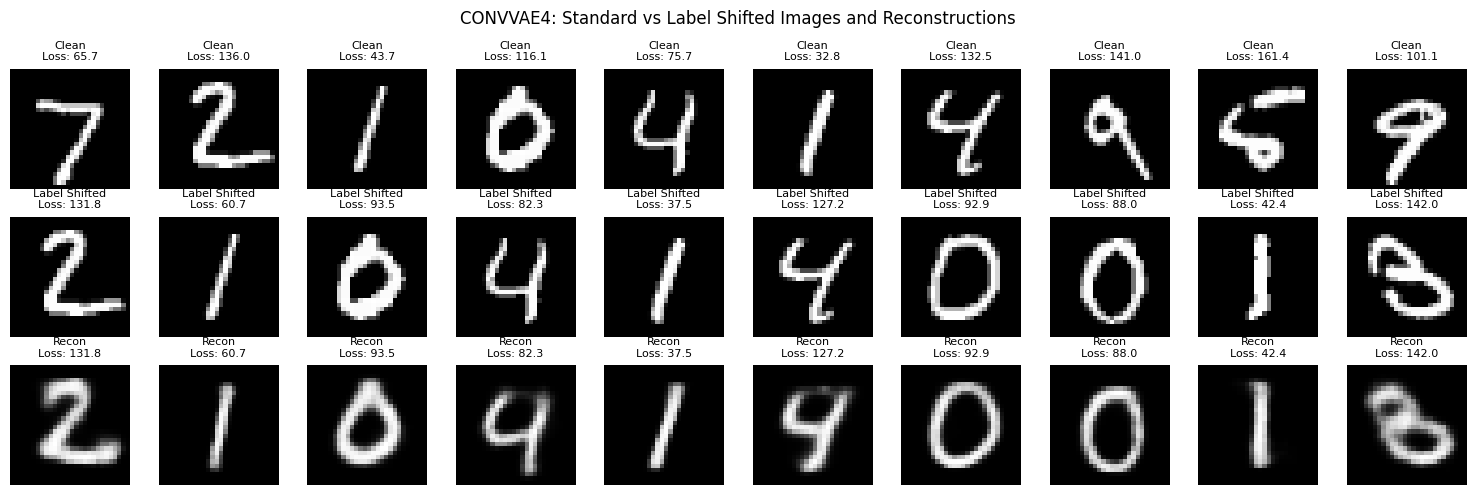

In [ ]:
visualize_reconstructions(labelshift_mnist_test_data, 'Label Shifted')


=== Reconstruction Visualization: Standard vs Occluded ===

CAE Reconstruction Losses:
  Standard images: [ 53.85579   78.62864   28.50621   73.13276   67.00745   28.064362
  99.0674    85.85861  157.40685   79.118065]
  Occluded images: [ 62.269993 150.10316   37.158173 188.18863   71.430115  28.064362
 141.37903  110.474625 220.70312  120.125084]
  Mean difference: 37.93


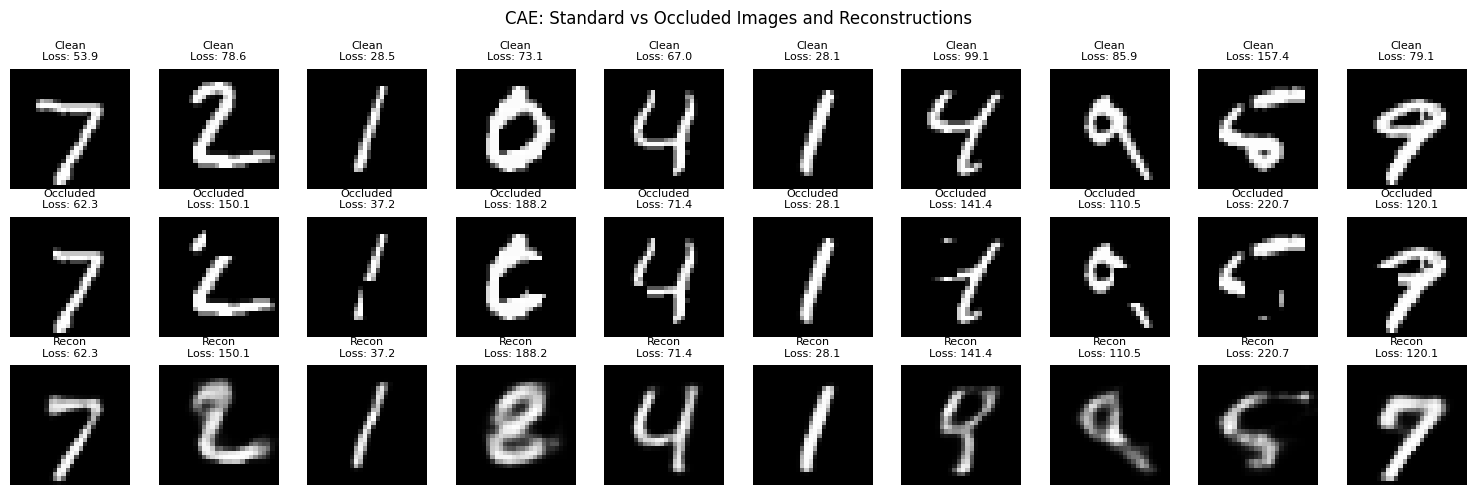


FCVAE Reconstruction Losses:
  Standard images: [ 55.34456   89.495926  34.6512    84.96112   72.26626   29.706398
 116.50512  110.63225  176.39658   95.20592 ]
  Occluded images: [ 75.77125  106.91556   41.83365  211.98485   76.97244   39.26481
 102.990265 102.56317  198.21768  117.000946]
  Mean difference: 20.83


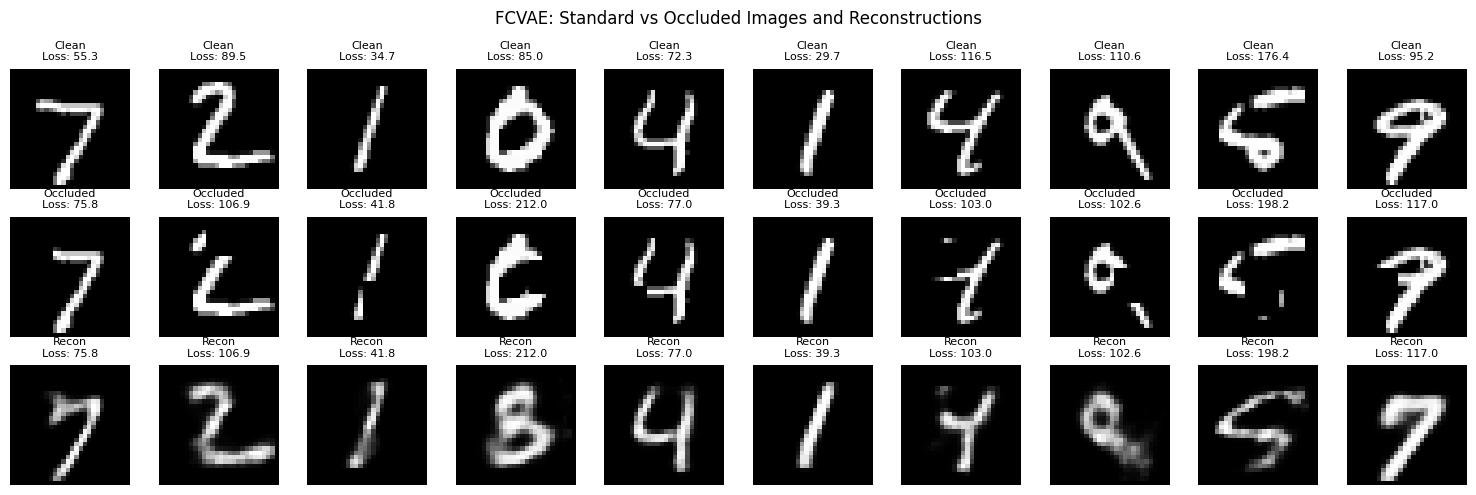


CONVVAE Reconstruction Losses:
  Standard images: [ 57.669403  90.09367   35.438545  75.986786  70.26326   34.269775
 102.7993    93.03148  160.41086   81.91365 ]
  Occluded images: [ 80.34854  124.16883   42.611977 154.73488   76.93251   33.22146
 110.82247  117.037735 187.73419  107.31218 ]
  Mean difference: 23.30


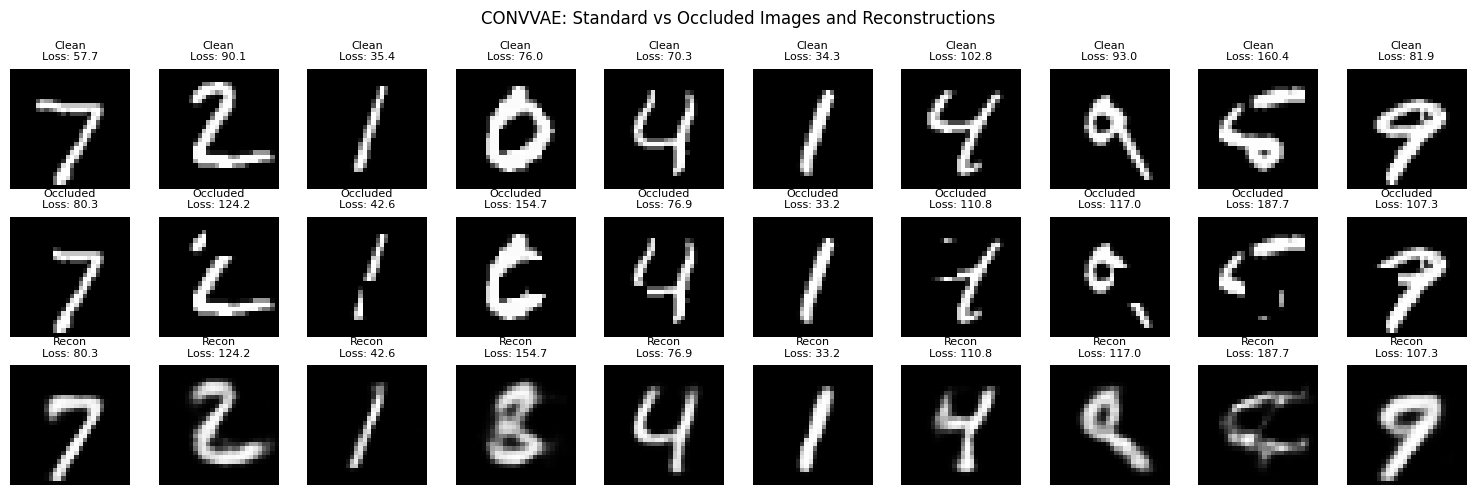


CONVVAE4 Reconstruction Losses:
  Standard images: [ 86.939316 132.16519   43.144753  96.55263  125.34219   40.295494
 129.0235   125.308304 170.7988   116.257385]
  Occluded images: [ 79.95428  149.47229   64.055756 184.16742   87.451324  44.25405
 151.86786  135.30019  205.33482  137.80977 ]
  Mean difference: 17.38


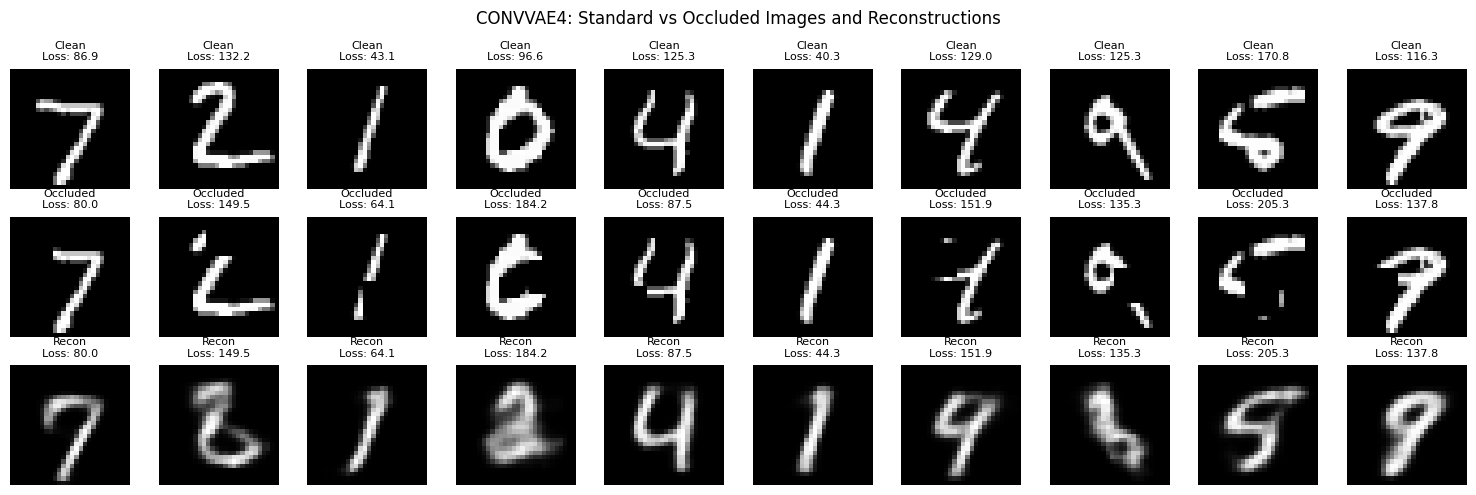

In [ ]:
visualize_reconstructions(occluded_mnist_test_data, 'Occluded')

# Per Digit Performance

In [ ]:
from collections import defaultdict

def compute_per_digit_metrics(latent_results):
    """
    Compute per-digit performance metrics (accuracy for CNN, recon loss for others).
    Returns a formatted display with metrics by digit for each model and dataset.
    """
    # Organize results by model and dataset
    results_by_model_dataset = defaultdict(lambda: defaultdict(dict))

    for result in latent_results:
        model = result['model']
        dataset = result['dataset']
        labels = result['labels'].numpy()

        if model == 'cnn':
            preds = result['preds'].numpy()
            per_sample_metric = (preds == labels).astype(float)  # 1 if correct, 0 if wrong
            metric_name = 'accuracy'
        else:
            per_sample_metric = result['per_sample_recon_loss'].numpy()
            metric_name = 'recon_loss'

        results_by_model_dataset[model][dataset]['labels'] = labels
        results_by_model_dataset[model][dataset]['metric'] = per_sample_metric
        results_by_model_dataset[model][dataset]['metric_name'] = metric_name

    # Print results formatted by model
    for model in sorted(results_by_model_dataset.keys()):
        print(f"\n{'='*80}")
        print(f"{model.upper()} - Per-Digit Performance")
        print(f"{'='*80}")

        metric_name = results_by_model_dataset[model][list(results_by_model_dataset[model].keys())[0]]['metric_name']

        # Create a summary table for each dataset
        for dataset in sorted(results_by_model_dataset[model].keys()):
            labels = results_by_model_dataset[model][dataset]['labels']
            metric = results_by_model_dataset[model][dataset]['metric']

            print(f"\n{dataset.upper()}:")
            print(f"{'Digit':<10} {'Count':<10} {metric_name.title():<15} {'Std Dev':<15}")
            print("-" * 50)

            # Compute per-digit stats
            for digit in range(10):
                digit_mask = labels == digit
                if digit_mask.sum() > 0:
                    digit_metrics = metric[digit_mask]
                    count = digit_mask.sum()
                    mean_metric = digit_metrics.mean()
                    std_metric = digit_metrics.std()

                    if metric_name == 'accuracy':
                        print(f"{digit:<10} {count:<10} {mean_metric:<15.4f} {std_metric:<15.4f}")
                    else:
                        print(f"{digit:<10} {count:<10} {mean_metric:<15.4f} {std_metric:<15.4f}")

            # Overall statistics
            overall_mean = metric.mean()
            overall_std = metric.std()
            print("-" * 50)
            print(f"{'OVERALL':<10} {len(metric):<10} {overall_mean:<15.4f} {overall_std:<15.4f}")

    # Create detailed DataFrame for further analysis
    data_records = []
    for result in latent_results:
        model = result['model']
        dataset = result['dataset']
        labels = result['labels'].numpy()

        if model == 'cnn':
            preds = result['preds'].numpy()
            metric_vals = (preds == labels).astype(float)
            metric_name = 'accuracy'
        else:
            metric_vals = result['per_sample_recon_loss'].numpy()
            metric_name = 'recon_loss'

        for digit in range(10):
            digit_mask = labels == digit
            if digit_mask.sum() > 0:
                digit_metrics = metric_vals[digit_mask]
                data_records.append({
                    'Model': model,
                    'Dataset': dataset,
                    'Digit': digit,
                    'Count': digit_mask.sum(),
                    'Mean_' + metric_name: digit_metrics.mean(),
                    'Std_' + metric_name: digit_metrics.std(),
                    'Min_' + metric_name: digit_metrics.min(),
                    'Max_' + metric_name: digit_metrics.max(),
                })

    df = pd.DataFrame(data_records)
    return df

# Compute and display per-digit metrics
df_per_digit = compute_per_digit_metrics(latent_results)



CAE - Per-Digit Performance

LABELSHIFTED0TO4:
Digit      Count      Recon_Loss      Std Dev        
--------------------------------------------------
0          980        85.7896         18.3311        
1          1135       34.7805         12.3883        
2          1032       96.2866         23.7321        
3          1010       89.3144         22.4247        
4          982        78.5451         22.4596        
--------------------------------------------------
OVERALL    5139       75.9401         30.3076        

NOISY:
Digit      Count      Recon_Loss      Std Dev        
--------------------------------------------------
0          980        630.0712        48.2811        
1          1135       585.3443        45.4878        
2          1032       625.6066        52.0313        
3          1010       630.6113        50.0170        
4          982        615.0526        48.3217        
5          892        641.7314        55.7071        
6          958        629.6430     

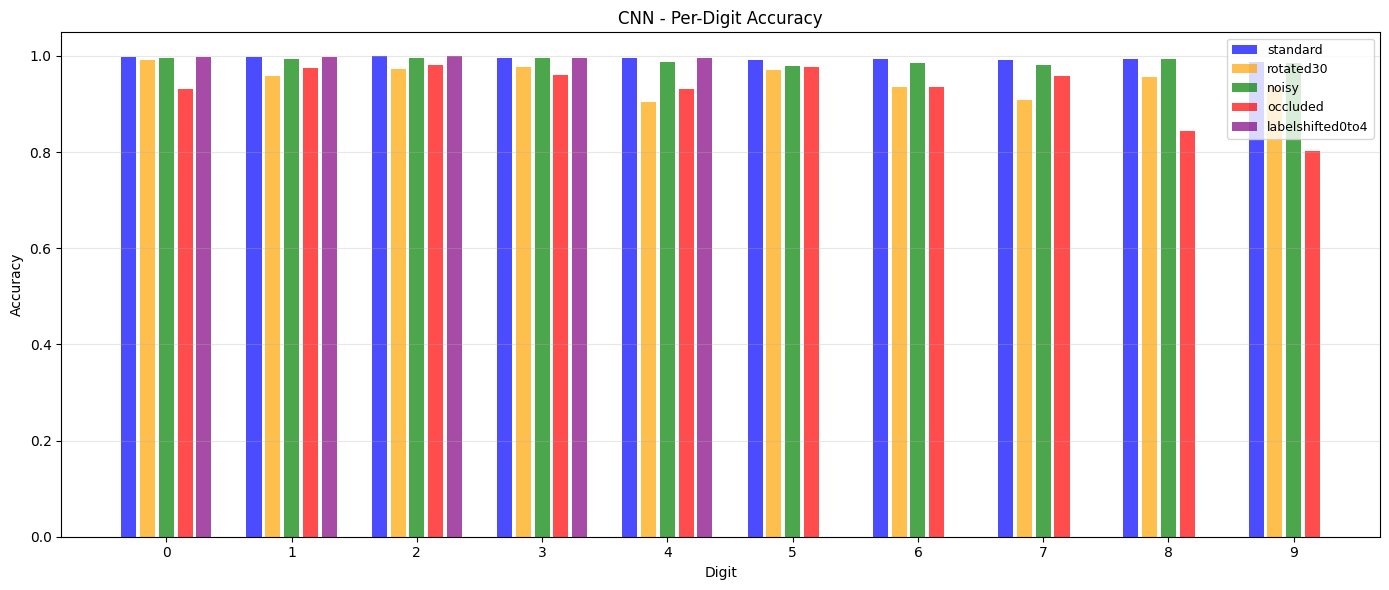

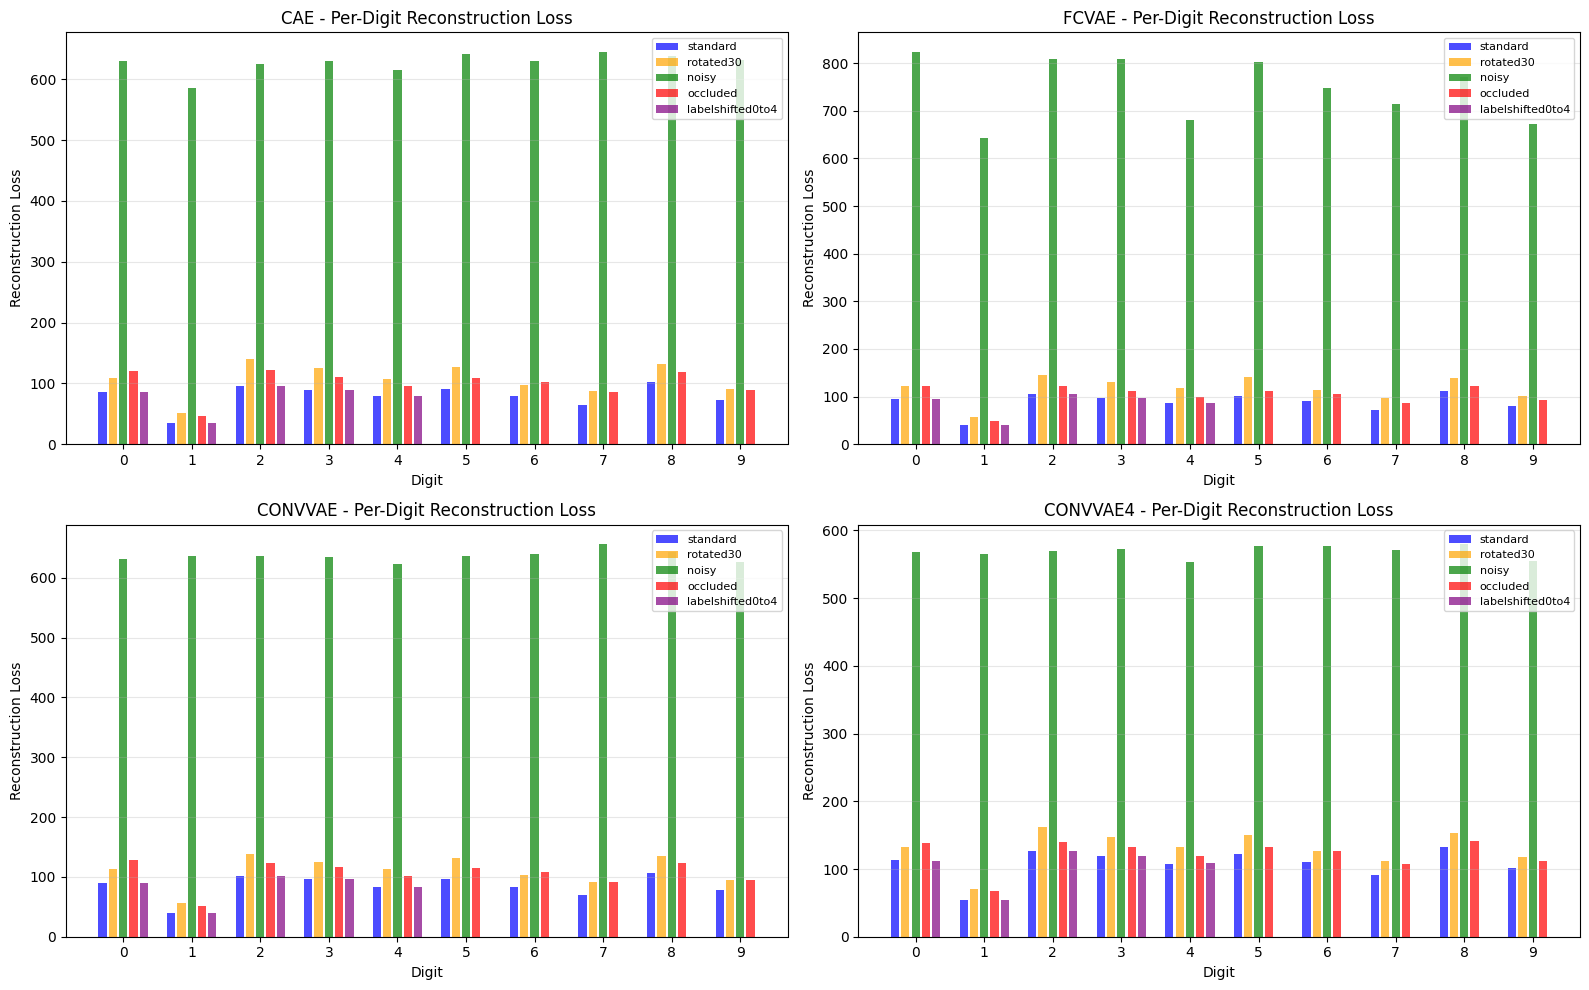


Per-Digit Performance Summary on Standard Dataset

CAE - Reconstruction Loss per digit:
  Digit 0: 85.7896 ± 18.3311
  Digit 1: 34.7805 ± 12.3883
  Digit 2: 96.2866 ± 23.7321
  Digit 3: 89.3144 ± 22.4247
  Digit 4: 78.5451 ± 22.4596
  Digit 5: 91.1985 ± 21.8188
  Digit 6: 78.8303 ± 20.7000
  Digit 7: 64.3376 ± 21.5063
  Digit 8: 102.5084 ± 23.7291
  Digit 9: 71.9518 ± 19.7222

FCVAE - Reconstruction Loss per digit:
  Digit 0: 95.1825 ± 19.2309
  Digit 1: 40.6052 ± 13.6639
  Digit 2: 105.8265 ± 25.1165
  Digit 3: 97.9503 ± 23.2163
  Digit 4: 87.3909 ± 21.5639
  Digit 5: 100.5679 ± 23.4601
  Digit 6: 91.3837 ± 22.9568
  Digit 7: 72.4770 ± 22.5241
  Digit 8: 110.6734 ± 25.2465
  Digit 9: 80.8827 ± 21.0335

CONVVAE - Reconstruction Loss per digit:
  Digit 0: 90.3728 ± 17.9506
  Digit 1: 39.5619 ± 12.7434
  Digit 2: 101.5440 ± 24.3793
  Digit 3: 95.6572 ± 24.1621
  Digit 4: 82.9621 ± 20.9450
  Digit 5: 96.6228 ± 21.5189
  Digit 6: 83.5684 ± 20.3246
  Digit 7: 70.0572 ± 21.9897
  Digit 8: 1

In [ ]:
# Visualize per-digit performance as bar plots
# Plot CNN - Accuracy separately

fig1, ax1 = plt.subplots(1, 1, figsize=(14, 6))

model_data = df_per_digit[df_per_digit['Model'] == 'cnn']
metric_col = 'Mean_accuracy'
y_label = 'Accuracy'
datasets_to_plot = ['standard', 'rotated30', 'noisy', 'occluded', 'labelshifted0to4']
colors_datasets = ['blue', 'orange', 'green', 'red', 'purple']

# Plot per digit performance for each dataset
for dataset_idx, dataset in enumerate(datasets_to_plot):
    dataset_data = model_data[model_data['Dataset'] == dataset]
    digits = dataset_data['Digit'].values
    metrics = dataset_data[metric_col].values

    x_pos = digits + (dataset_idx - 2) * 0.15  # Offset bars for each dataset
    ax1.bar(x_pos, metrics, width=0.12, label=dataset, alpha=0.7, color=colors_datasets[dataset_idx])

ax1.set_xlabel('Digit')
ax1.set_ylabel(y_label)
ax1.set_title('CNN - Per-Digit Accuracy')
ax1.set_xticks(range(10))
ax1.legend(fontsize=9, loc='best')
ax1.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Plot remaining models with Reconstruction Loss
fig2, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

models_to_plot = ['cae', 'fcVAE', 'convVAE', 'convVAE4']

for idx, model in enumerate(models_to_plot):
    ax = axes[idx]

    model_data = df_per_digit[df_per_digit['Model'] == model]
    metric_col = 'Mean_recon_loss'
    y_label = 'Reconstruction Loss'

    # Plot per digit performance for each dataset
    for dataset_idx, dataset in enumerate(datasets_to_plot):
        dataset_data = model_data[model_data['Dataset'] == dataset]
        digits = dataset_data['Digit'].values
        metrics = dataset_data[metric_col].values

        x_pos = digits + (dataset_idx - 2) * 0.15  # Offset bars for each dataset
        ax.bar(x_pos, metrics, width=0.12, label=dataset, alpha=0.7, color=colors_datasets[dataset_idx])

    ax.set_xlabel('Digit')
    ax.set_ylabel(y_label)
    ax.set_title(f'{model.upper()} - Per-Digit {y_label}')
    ax.set_xticks(range(10))
    ax.legend(fontsize=8, loc='best')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Create a heatmap showing per-digit performance for each model on standard dataset
print("\n" + "="*80)
print("Per-Digit Performance Summary on Standard Dataset")
print("="*80)

for model in models_to_plot:
    model_data = df_per_digit[(df_per_digit['Model'] == model) & (df_per_digit['Dataset'] == 'standard')]

    if model == 'cnn':
        metric_col = 'Mean_accuracy'
        print(f"\n{model.upper()} - Accuracy per digit:")
    else:
        metric_col = 'Mean_recon_loss'
        print(f"\n{model.upper()} - Reconstruction Loss per digit:")

    std_col = metric_col.replace('Mean_', 'Std_')  # Fix: construct std column name correctly

    for _, row in model_data.iterrows():
        digit = int(row['Digit'])
        metric_val = row[metric_col]
        std_val = row[std_col]
        print(f"  Digit {digit}: {metric_val:.4f} ± {std_val:.4f}")


# UMAPs

In [ ]:
# === UMAP VISUALIZATIONS ===
# Visualization of each model's latent space changes across datasets

# Define configuration and helper functions
datasets_to_plot = ["standard", "rotated30", "noisy", "occluded", "labelshifted0to4"]
dataset_names = {"standard": "Standard", "rotated30": "Rotated", "noisy": "Noisy", "occluded": "Occluded", "labelshifted0to4": "Label Shift"}
dataset_colors = {"standard": "tab:blue", "rotated30": "tab:orange", "noisy": "tab:green", "occluded": "tab:red", "labelshifted0to4": "tab:purple"}

def prepare_model_umap(model_key, model_display_name, latent_results, datasets_to_plot):
    """
    Prepare UMAP data for a single model across all datasets.

    Args:
        model_key: Key to filter latent_results (e.g., "cae", "convVAE", "convVAE4")
        model_display_name: Display name for plots (e.g., "CAE", "Conv VAE (β=4.0)")
        latent_results: List of latent result dictionaries
        datasets_to_plot: List of datasets to include

    Returns:
        Tuple of (by_dataset dict, umap_data dict, model_display_name)
    """
    # Extract and organize results by dataset
    model_results = [r for r in latent_results if r["model"] == model_key and r["dataset"] in datasets_to_plot]
    by_dataset = {r["dataset"]: r for r in model_results}

    print(f"{model_display_name} datasets available: {list(by_dataset.keys())}")

    # Fit UMAP on standard dataset and transform all datasets
    umap_data = {}
    if by_dataset:
        umap_reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
        standard_latents = by_dataset['standard']['latents'].numpy()
        umap_reducer.fit(standard_latents)

        for dataset in datasets_to_plot:
            if dataset in by_dataset:
                latents = by_dataset[dataset]['latents'].numpy()
                umap_data[dataset] = umap_reducer.transform(latents)

    return by_dataset, umap_data, model_display_name

def plot_model_umap(model_name, umap_data, by_dataset, datasets_to_plot, dataset_names, dataset_colors):
    """
    Create all UMAP visualizations for a single model.

    Args:
        model_name: Display name of the model
        umap_data: Dictionary mapping dataset names to UMAP coordinates
        by_dataset: Dictionary mapping dataset names to latent result dictionaries
        datasets_to_plot: List of dataset names to plot
        dataset_names: Dictionary mapping dataset keys to display names
        dataset_colors: Dictionary mapping dataset keys to colors
    """

    # Visualization 1: Dataset comparison (by color)
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    for dataset in datasets_to_plot:
        if dataset in umap_data:
            umap_coords = umap_data[dataset]
            ax.scatter(umap_coords[:, 0], umap_coords[:, 1],
                      s=8, alpha=0.5, label=dataset_names[dataset], color=dataset_colors[dataset])
    ax.set_xlabel('UMAP-1')
    ax.set_ylabel('UMAP-2')
    ax.set_title(f'{model_name} Latent Space: Dataset Comparison')
    ax.legend(fontsize=10, loc='best')
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Visualization 2: Digit overlap on standard dataset
    if 'standard' in umap_data:
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        labels = by_dataset['standard']['labels'].numpy()
        scatter = ax.scatter(umap_data['standard'][:, 0], umap_data['standard'][:, 1],
                            c=labels, cmap='tab10', s=10, alpha=0.6, edgecolors='k', linewidth=0.3)
        ax.set_xlabel('UMAP-1')
        ax.set_ylabel('UMAP-2')
        ax.set_title(f'{model_name} Latent Space: Digit Separation (Standard Dataset)')
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Digit', rotation=270, labelpad=15)
        ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    # Visualization 3: Latent space drift - Standard vs each perturbation
    if len(umap_data) > 1:
        perturbations = [d for d in datasets_to_plot if d != 'standard' and d in umap_data]
        n_perturb = len(perturbations)

        fig, axes = plt.subplots(1, n_perturb, figsize=(5 * n_perturb, 5))
        if n_perturb == 1:
            axes = [axes]

        standard_coords = umap_data['standard']
        standard_labels = by_dataset['standard']['labels'].numpy()

        for idx, perturbation in enumerate(perturbations):
            ax = axes[idx]
            perturb_coords = umap_data[perturbation]
            perturb_labels = by_dataset[perturbation]['labels'].numpy()

            # Plot standard as background
            ax.scatter(standard_coords[:, 0], standard_coords[:, 1],
                      s=6, alpha=0.3, c='gray', label='Standard', marker='o')
            # Plot perturbation as overlay
            scatter = ax.scatter(perturb_coords[:, 0], perturb_coords[:, 1],
                               c=perturb_labels, cmap='tab10', s=10, alpha=0.7, marker='*', edgecolors='k', linewidth=0.2)

            ax.set_xlabel('UMAP-1')
            ax.set_ylabel('UMAP-2')
            ax.set_title(f'{dataset_names[perturbation]} vs Standard')
            ax.legend(fontsize=8, loc='best')
            ax.grid(alpha=0.3)

        plt.suptitle(f'{model_name} Latent Space: Perturbation Drift', fontsize=13, y=1.00)
        plt.tight_layout()
        plt.show()

    # Visualization 4: Digit overlap comparison - All datasets
    if len(umap_data) > 1:
        fig, axes = plt.subplots(2, 3, figsize=(16, 10))
        axes = axes.flatten()

        for plot_idx, dataset in enumerate(datasets_to_plot):
            if dataset in umap_data and plot_idx < 6:
                ax = axes[plot_idx]
                labels = by_dataset[dataset]['labels'].numpy()
                scatter = ax.scatter(umap_data[dataset][:, 0], umap_data[dataset][:, 1],
                                   c=labels, cmap='tab10', s=8, alpha=0.6, edgecolors='k', linewidth=0.2)
                ax.set_xlabel('UMAP-1')
                ax.set_ylabel('UMAP-2')
                ax.set_title(f'{dataset_names[dataset]} Dataset')
                ax.grid(alpha=0.3)
                cbar = plt.colorbar(scatter, ax=ax)
                cbar.set_label('Digit', rotation=270, labelpad=15)

        # Hide unused subplots
        for plot_idx in range(len(datasets_to_plot), 6):
            axes[plot_idx].axis('off')

        plt.suptitle(f'{model_name} Latent Space: Digit Distribution Across Datasets', fontsize=14, y=1.00)
        plt.tight_layout()
        plt.show()

# Configuration and loop through each model
models_config = [
    ("cae", "CAE"),
    ("fcVAE", "FC VAE"),
    ("convVAE", "Conv VAE (β=1.0)"),
    ("convVAE4", "Conv VAE (β=4.0)")
]

for model_key, model_display_name in models_config:
    print(f"\n{'='*60}")
    print(f"Generating UMAPs for {model_display_name}")
    print(f"{'='*60}")

    by_dataset, umap_data, name = prepare_model_umap(model_key, model_display_name, latent_results, datasets_to_plot)
    plot_model_umap(name, umap_data, by_dataset, datasets_to_plot, dataset_names, dataset_colors)

Output hidden; open in https://colab.research.google.com to view.

**Why beta=4 shows looser, overlapping clusters:**

* Stricter prior constraint: Higher beta heavily penalizes divergence from the standard normal prior N(0,1). This forces the model to:

* * Keep latents closer to zero mean
* * Maintain unit variance
* * Stay within a tighter region of the latent space
* * Result: Less room to spread out and separate clusters

* Reconstruction vs. regularization trade-off:

* * Beta=1 (standard ELBO): Can prioritize reconstruction quality and learn more separated, interpretable clusters
* * Beta=4: Must sacrifice some reconstruction quality and cluster separation to satisfy the stronger regularization. The model is essentially "forced" to compress and overlap representations more

* Why the different scales:

* * Beta=1 latents have higher variance and range (your observation: -5 to 12.5)
* * Beta=4 latents are more constrained near the origin (your observation: 0 to 10)
* * UMAP is just faithfully representing the intrinsic structure of each latent space

* What this means for the analysis:

* * Beta=1 gives you cleaner digit separation, so it might be better for architectural comparison (to see clear differences between CAE, FC VAE, Conv VAE)
* * Beta=4 enforces better adherence to the standard normal prior, which is theoretically "more correct" from a VAE perspective, but produces more entangled representations


Generating overlaid model comparison
CAE datasets available: ['standard', 'rotated30', 'noisy', 'occluded', 'labelshifted0to4']


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


FC VAE datasets available: ['standard', 'rotated30', 'noisy', 'occluded', 'labelshifted0to4']


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Conv VAE (β=1.0) datasets available: ['standard', 'rotated30', 'noisy', 'occluded', 'labelshifted0to4']


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Conv VAE (β=4.0) datasets available: ['standard', 'rotated30', 'noisy', 'occluded', 'labelshifted0to4']


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipython-input-123658759.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


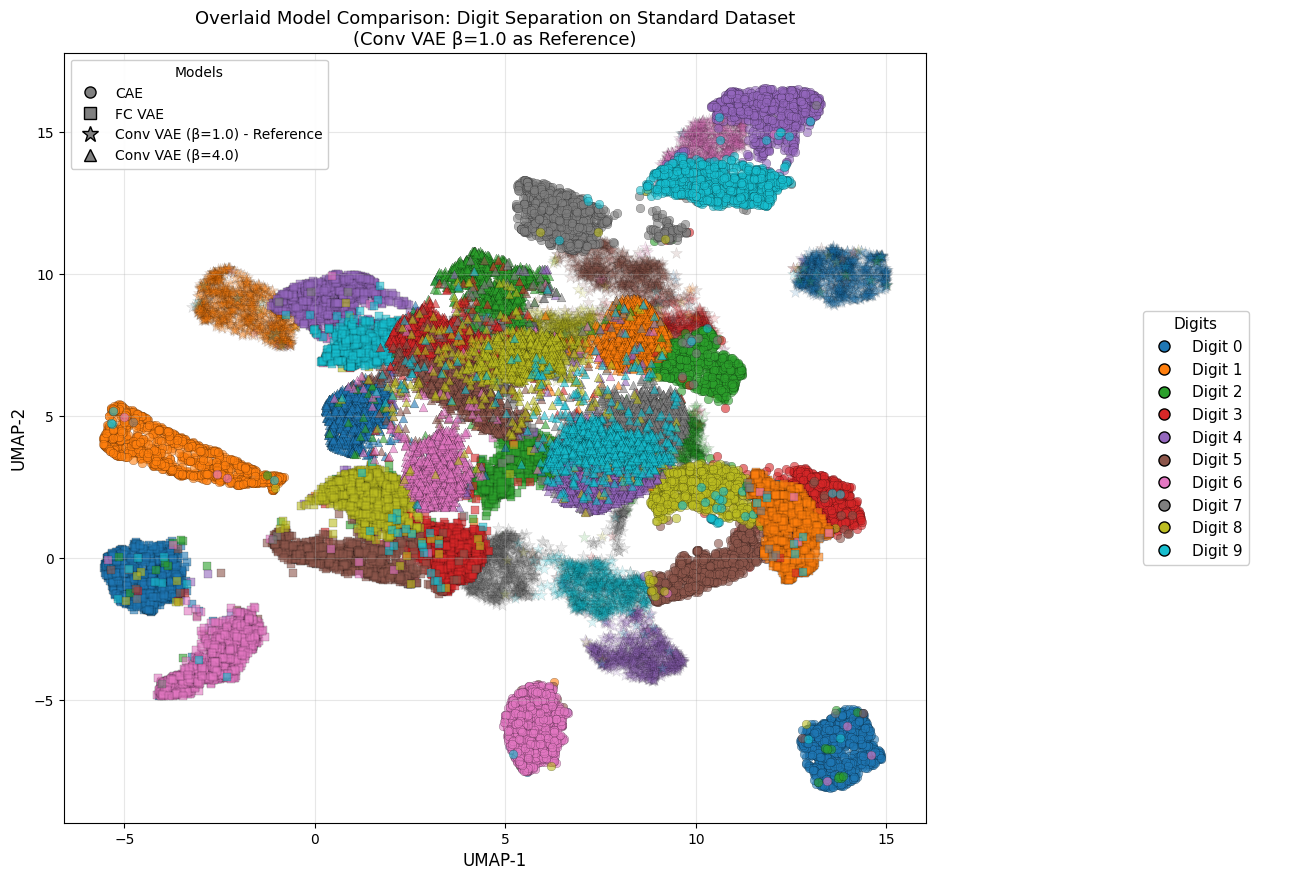

In [ ]:
# Overlaid model comparison - Standard dataset digit separation
print(f"\n{'='*60}")
print(f"Generating overlaid model comparison")
print(f"{'='*60}")

# Prepare UMAP data for all models
all_models_umap = {}
for model_key, model_display_name in models_config:
    by_dataset, umap_data, name = prepare_model_umap(model_key, model_display_name, latent_results, datasets_to_plot)
    all_models_umap[name] = {
        'umap_data': umap_data,
        'by_dataset': by_dataset,
        'model_key': model_key
    }

# Create figure with overlaid models - using GridSpec for side legend
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(1, 2, figure=fig, width_ratios=[4, 1], wspace=0.3)
ax = fig.add_subplot(gs[0])
ax_legend = fig.add_subplot(gs[1])

# Define model display properties
model_markers = {
    "CAE": "o",
    "FC VAE": "s",
    "Conv VAE (β=1.0)": "*",
    "Conv VAE (β=4.0)": "^"
}

model_alphas = {
    "Conv VAE (β=1.0)": 0.15,  # Background reference model - low alpha
    "CAE": 0.6,
    "FC VAE": 0.6,
    "Conv VAE (β=4.0)": 0.6
}

model_sizes = {
    "Conv VAE (β=1.0)": 80,  # Larger background reference
    "CAE": 40,
    "FC VAE": 40,
    "Conv VAE (β=4.0)": 40
}

# Create colormap for digits (0-9)
cmap = plt.get_cmap('tab10')

# Plot ConvVAE1 as background reference first
if 'Conv VAE (β=1.0)' in all_models_umap:
    ref_model = all_models_umap['Conv VAE (β=1.0)']
    if 'standard' in ref_model['umap_data']:
        labels = ref_model['by_dataset']['standard']['labels'].numpy()
        umap_coords = ref_model['umap_data']['standard']

        # Plot each digit for the reference model
        for digit in range(10):
            digit_mask = labels == digit
            ax.scatter(umap_coords[digit_mask, 0], umap_coords[digit_mask, 1],
                      c=[cmap(digit)], s=model_sizes['Conv VAE (β=1.0)'],
                      alpha=model_alphas['Conv VAE (β=1.0)'],
                      marker=model_markers['Conv VAE (β=1.0)'],
                      edgecolors='k', linewidth=0.3)

# Overlay other models
for model_name in ["CAE", "FC VAE", "Conv VAE (β=4.0)"]:
    if model_name in all_models_umap:
        model_data = all_models_umap[model_name]
        if 'standard' in model_data['umap_data']:
            labels = model_data['by_dataset']['standard']['labels'].numpy()
            umap_coords = model_data['umap_data']['standard']

            # Plot each digit
            for digit in range(10):
                digit_mask = labels == digit
                ax.scatter(umap_coords[digit_mask, 0], umap_coords[digit_mask, 1],
                          c=[cmap(digit)], s=model_sizes[model_name],
                          alpha=model_alphas[model_name],
                          marker=model_markers[model_name],
                          edgecolors='k', linewidth=0.2)

ax.set_xlabel('UMAP-1', fontsize=12)
ax.set_ylabel('UMAP-2', fontsize=12)
ax.set_title('Overlaid Model Comparison: Digit Separation on Standard Dataset\n(Conv VAE β=1.0 as Reference)', fontsize=13)
ax.grid(alpha=0.3)

# Create model legend on main axis
from matplotlib.lines import Line2D
model_legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=8, label='CAE', markeredgecolor='k'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', markersize=8, label='FC VAE', markeredgecolor='k'),
    Line2D([0], [0], marker='*', color='w', markerfacecolor='gray', markersize=12, label='Conv VAE (β=1.0) - Reference', markeredgecolor='k'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='gray', markersize=8, label='Conv VAE (β=4.0)', markeredgecolor='k'),
]
ax.legend(handles=model_legend_elements, fontsize=10, loc='upper left', title='Models', framealpha=0.95)

# Create digit legend on right side
digit_legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(d),
                                markersize=8, label=f'Digit {d}', markeredgecolor='k') for d in range(10)]
ax_legend.legend(handles=digit_legend_elements, fontsize=11, loc='center', title='Digits', frameon=True,
                 framealpha=0.95, title_fontsize=11)
ax_legend.axis('off')

plt.tight_layout()
plt.show()